# Ne19_snr_tests 1/20/2023

Testing SNR cuts in katydid of 7,8,9,10,11



In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
from scipy import integrate

# Jupyter Lab imports.
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed

# Path to local imports.
sys.path.append("/home/drew/He6CRES/rocks_analysis_pipeline/")
from results import ExperimentResults
from rocks_utility import he6cres_db_query


# Path to local imports. Alter to match your machine. 
sys.path.append("/home/drew/He6CRES/he6-cres-spec-sims/")

# Local imports.
import he6_cres_spec_sims.spec_tools.spec_calc.spec_calc as sc
import he6_cres_spec_sims.spec_tools.beta_source.beta_spectrum as bs

# Local imports for plotting ratios and such. 
import analysis_functions.ratio_experiment as re
import analysis_functions.ratio_prediction as rp

## Load Ne19 data

* Only loo

In [3]:
local_dir = "/media/drew/T7 Shield/rocks_analysis/saved_experiments"
include_root_files = False
max_root_files_to_grab = 2
rebuild_experiment_dir = False


snrs = [7,8,9,10,11]
aids = [19,23,20,24,21]
experiment_names = [f"ne_snr{snr}_fn20" for snr in snrs]
print(experiment_names)


ne_snr_results = [ ExperimentResults(local_dir = local_dir, 
                                     experiment_name = experiment_name, 
                                     analysis_id = aid, 
                                     include_root_files = include_root_files,
                                     max_root_files_to_grab = max_root_files_to_grab,
                                     rebuild_experiment_dir=rebuild_experiment_dir,
                                    )
                  for (experiment_name, aid) in zip(experiment_names[1:-1], aids[1:-1])]


['ne_snr7_fn20', 'ne_snr8_fn20', 'ne_snr9_fn20', 'ne_snr10_fn20', 'ne_snr11_fn20']
Keeping existing experiment directory.


Keeping existing experiment directory.


Keeping existing experiment directory.




## Load He6 data

In [4]:
local_dir = "/media/drew/T7 Shield/rocks_analysis/saved_experiments"
include_root_files = False
max_root_files_to_grab = 2
rebuild_experiment_dir = False


snrs = [7,8,9,10,11]
aids = [16,19,17,20,18]
experiment_names = [f"he_snr{snr}_fn20" for snr in snrs]
print(experiment_names)

he_snr_results = [ ExperimentResults(local_dir = local_dir, 
                                     experiment_name = experiment_name, 
                                     analysis_id = aid, 
                                     include_root_files = include_root_files,
                                     max_root_files_to_grab = max_root_files_to_grab,
                                     rebuild_experiment_dir=rebuild_experiment_dir,
                                    )
                  for (experiment_name, aid) in zip(experiment_names[1:-1], aids[1:-1])]


['he_snr7_fn20', 'he_snr8_fn20', 'he_snr9_fn20', 'he_snr10_fn20', 'he_snr11_fn20']
Keeping existing experiment directory.


Keeping existing experiment directory.


Keeping existing experiment directory.




### EDA of SNR tests

In [5]:
# Aggregate the results.
snr_cuts = np.array(list(range(8,11)))
snr_study = { "ne": dict(zip(snr_cuts,ne_snr_results)),
              "he": dict(zip(snr_cuts,he_snr_results))}

In [6]:
counts_ne = np.array([snr_study["ne"][cut].events.shape[0] for cut in snr_cuts])
counts_he = np.array([snr_study["he"][cut].events.shape[0] for cut in snr_cuts])

## Total Events Detected vs SNR cut

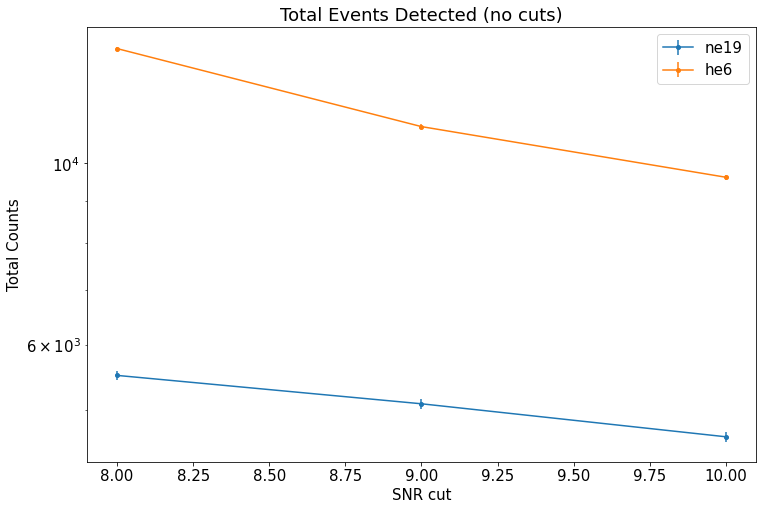

In [7]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(12,8))

plt.errorbar(snr_cuts, counts_ne, yerr = (counts_ne)**.5, label = "ne19", marker='o', ms=4)
plt.errorbar(snr_cuts, counts_he, yerr = (counts_ne)**.5, label = "he6", marker='o', ms=4)

ax.set_yscale("log")
ax.set_title("Total Events Detected (no cuts)")
ax.set_xlabel('SNR cut')
ax.set_ylabel('Total Counts')
ax.legend()



plt.show()

## Total Events Detected vs Field vs SNR Cut

* Dropping 7 as it's janky. 

In [8]:
# Define cuts to use later on.
alt_cuts = {"EventStartFreq": 300e6, "EventNBins": 100, "mTotalSNR": 0}
alt_cuts = {"EventStartFreq": 650e6, "EventNBins": 100, "mTotalSNR": 35}

[1.855e+10 1.910e+10]


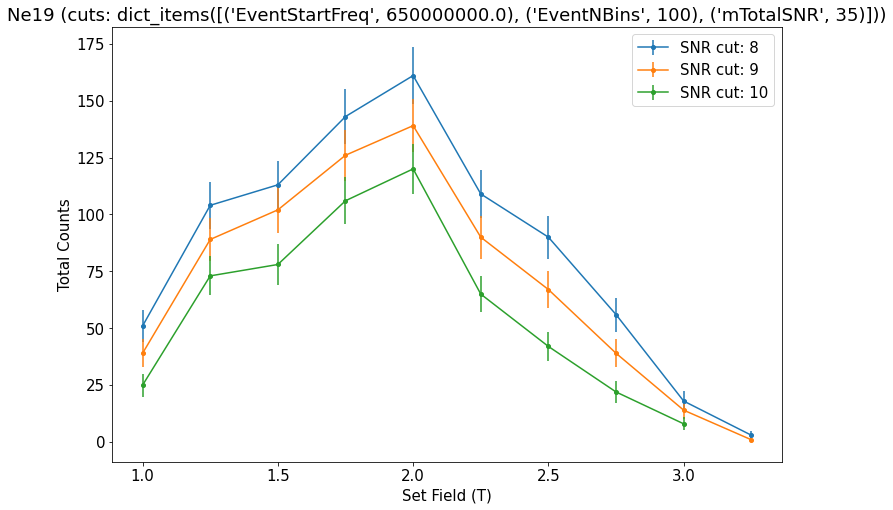

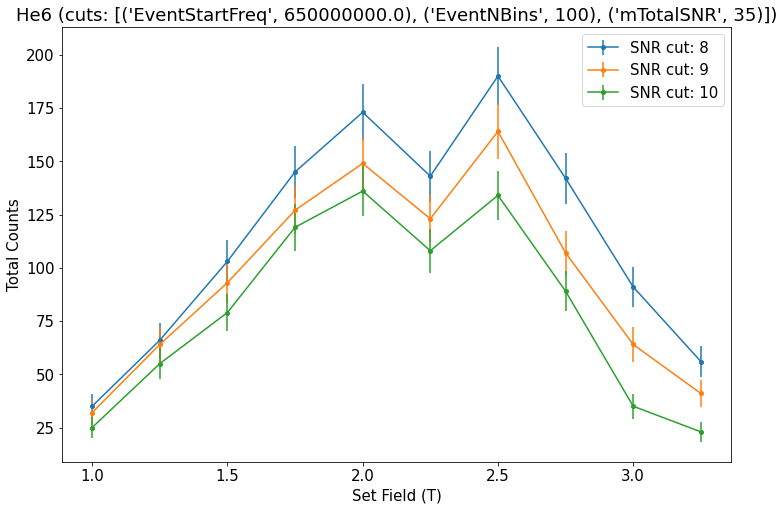

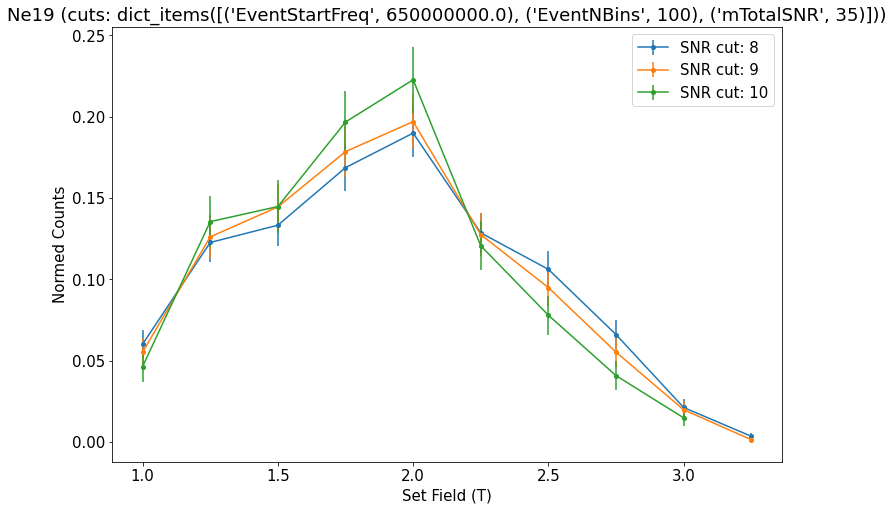

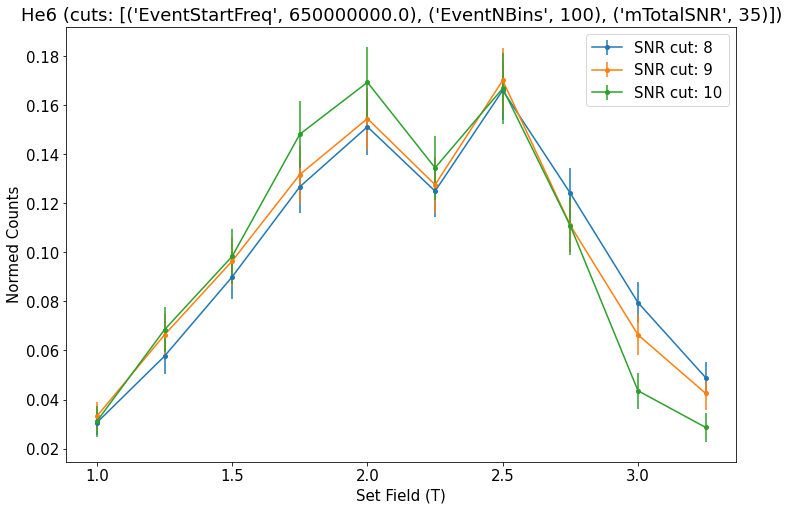

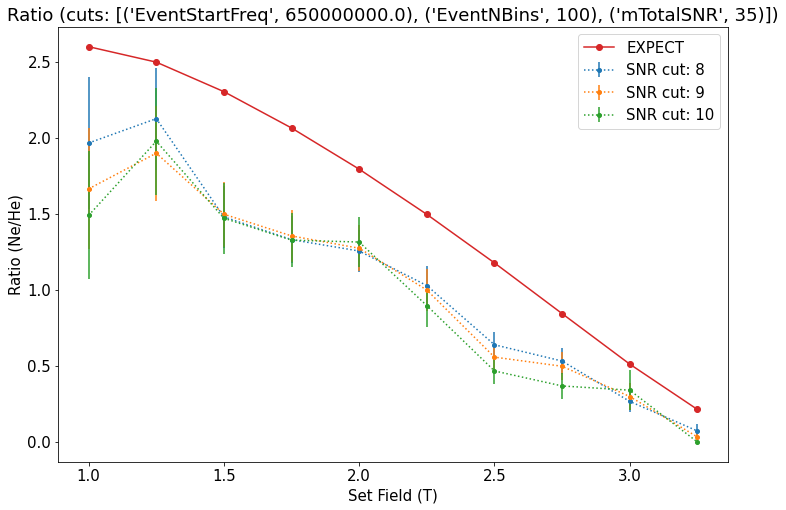

In [9]:
%matplotlib inline
plt.rcParams.update({'font.size': 15})
fig0, ax0 = plt.subplots(figsize=(12,8))
fig1, ax1 = plt.subplots(figsize=(12,8))
fig2, ax2 = plt.subplots(figsize=(12,8))
fig3, ax3 = plt.subplots(figsize=(12,8))
fig4, ax4 = plt.subplots(figsize=(12,8))

for cut in snr_cuts: 
    ne_events = snr_study["ne"][cut].events
    he_events = snr_study["he"][cut].events
    
    ne_condition = ( (ne_events.EventStartFreq > alt_cuts["EventStartFreq"])
                & (ne_events.EventNBins > alt_cuts["EventNBins"])
                & (ne_events.mTotalSNR > alt_cuts["mTotalSNR"])
                & (ne_events.set_field > .75))
    
    he_condition = ( (he_events.EventStartFreq > alt_cuts["EventStartFreq"])
                & (he_events.EventNBins > alt_cuts["EventNBins"])
                & (he_events.mTotalSNR > alt_cuts["mTotalSNR"])
                & (he_events.set_field > .75) )
    
    ne_events_cut = ne_events[ne_condition]
    he_events_cut = he_events[he_condition]
    
    # Counts plots
    ne_counts = ne_events_cut.groupby("set_field").run_id.count()
    he_counts = he_events_cut.groupby("set_field").run_id.count()
    
    # print(ne_counts, he_counts)
    
    ax0.errorbar(ne_counts.index, ne_counts.values, yerr = (ne_counts.values)**.5, label = f"SNR cut: {cut}", marker='o', ms=4)
    ax1.errorbar(he_counts.index, he_counts.values, yerr = (he_counts.values)**.5, label = f"SNR cut: {cut}", marker='o', ms=4)
    
    # Normed counts plots
    ne_counts_norm = ne_counts / ne_counts.sum()
    he_counts_norm = he_counts / he_counts.sum()
    ne_err = (ne_counts)**.5/ ne_counts.sum()
    he_err = (he_counts)**.5/ he_counts.sum()
    
    ax2.errorbar(ne_counts_norm.index, ne_counts_norm.values, yerr = ne_err.values, label = f"SNR cut: {cut}", marker='o', ms=4)
    ax3.errorbar(he_counts_norm.index, he_counts_norm.values, yerr = he_err.values, label = f"SNR cut: {cut}", marker='o', ms=4)
    
    # Ratio plot 
    ratio = (ne_counts_norm/he_counts_norm).fillna(0)
    ratio_err = ratio*(1/ne_counts + 1/he_counts)**.5
    # print(ratio, ratio_err)
    ratio_err = ratio_err.fillna(0)
    
    ax4.errorbar(ratio.index, ratio.values, yerr = ratio_err.values, label = f"SNR cut: {cut}", marker='o',ls = 'dotted', ms=4)

## PREDICTION FOR RATIO PLOT. Taking this out for now.
# WHY DOES THIS SEEM TO BE SO DIFFERENT THAN LAST TIME. 
    
set_fields = np.arange(1.0,3.3,.25)
freq_BW = np.array([alt_cuts["EventStartFreq"]+ 17.9e9, 19.1e9])
print(freq_BW)
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

rates = rp.AUC_expectation(set_fields, freq_BWs, b = 0, plot = False)

ax4.plot(rates.index, rates.Ratio,  label = f"EXPECT", marker='o', ms=6)
    

# ax.set_yscale("log")
ax0.set_title(f"Ne19 (cuts: {alt_cuts.items()})")
ax0.set_xlabel('Set Field (T)')
ax0.set_ylabel('Total Counts')
ax0.legend()

ax1.set_title(f"He6 (cuts: {list(alt_cuts.items())})")
ax1.set_xlabel('Set Field (T)')
ax1.set_ylabel('Total Counts')
ax1.legend()

ax2.set_title(f"Ne19 (cuts: {alt_cuts.items()})")
ax2.set_xlabel('Set Field (T)')
ax2.set_ylabel('Normed Counts')
ax2.legend()

ax3.set_title(f"He6 (cuts: {list(alt_cuts.items())})")
ax3.set_xlabel('Set Field (T)')
ax3.set_ylabel('Normed Counts')
ax3.legend()

ax4.set_title(f"Ratio (cuts: {list(alt_cuts.items())})")
ax4.set_xlabel('Set Field (T)')
ax4.set_ylabel('Ratio (Ne/He)')
ax4.legend()

plt.show()

## Comparing to MC expectation. 

* Looking at different cuts in start freq. 
* START HERE.

## Investigating monitor: 

In [10]:
def build_normalization(root_files):  
    condition = (root_files.root_file_exists ==True)
    normalize_df = root_files[condition].groupby(["run_id", "file_id"])[["monitor_rate", "set_field"]].first().reset_index()
    display(normalize_df)
for cut in snr_cuts[1:]: 
    ne_root_files = snr_study["ne"][cut].root_files
    he_root_files = snr_study["he"][cut].root_files
    
    display(ne_root_files.groupby("run_id").root_file_exists.sum().mean())
    build_normalization(ne_root_files)
    


19.894736842105264

,run_id,file_id,monitor_rate,set_field
0,492,0,13773.77,3.25
1,492,1,13753.75,3.25
2,492,2,13586.41,3.25
3,492,3,14010.00,3.25
4,492,4,13723.72,3.25
...,...,...,...,...
1129,561,15,11490.00,0.75
1130,561,16,11560.00,0.75
1131,561,17,11520.00,0.75
1132,561,18,11741.74,0.75


19.666666666666668

,run_id,file_id,monitor_rate,set_field
0,492,0,13773.77,3.25
1,492,1,13753.75,3.25
2,492,2,13586.41,3.25
3,492,3,14010.00,3.25
4,492,4,13723.72,3.25
...,...,...,...,...
1116,561,15,11490.00,0.75
1117,561,16,11560.00,0.75
1118,561,17,11520.00,0.75
1119,561,18,11741.74,0.75


In [11]:
# print(f"fraction of spectrum remaining post cut: {condition.mean()}")
valid_events = events[condition]

condition = (root_files.root_file_exists ==True)
normalize_df = root_files[condition].groupby(["run_id", "file_id"])[["monitor_rate", "set_field"]].first().reset_index()

event_counts = valid_events.groupby(["run_id", "file_id"]).EventID.count().to_frame("event_count").reset_index()

spec1 = pd.merge(normalize_df, event_counts, how = "left", left_on = ["run_id", "file_id"], right_on = ["run_id", "file_id"])
spec1 = spec1.fillna(0)
# display(spec1.head())

spec2 = spec1.groupby(["set_field"])[["event_count", "monitor_rate"]].sum().reset_index()

spec2 = spec2.rename(columns={'monitor_rate':'tot_monitor_rate'})

spec3 = spec1.groupby(["set_field"]).event_count.count().to_frame("seconds_of_data").reset_index()
spec4 = pd.merge(spec2, spec3, how = "inner", left_on = ["set_field"], right_on = ["set_field"])

spec4["normed_tot_monitor_rate"] = spec4["tot_monitor_rate"] / spec4["tot_monitor_rate"].mean()

spec4["mon_adjusted_count"] = spec4["event_count"]/spec4["normed_tot_monitor_rate"]
spec4["mon_adjusted_count_uncert"] =  spec4["mon_adjusted_count"]**.5

NameError: name 'events' is not defined

## Methods for building spectra (need to build in to module)

TODO: 
* USE THE below and compare to expectation. Then do the same for the full run. 

In [ ]:


def plot_experimental_spectra(ratio_exp, ax ): 
    
    for col in ["He6", "Ne19"]:
        ax.errorbar(ratio_exp.index, ratio_exp[col], yerr = ratio_exp["s"+col], label = f"{col}, experiment", marker='o', ms=4)

    return None

def plot_predicted_spectra(ratio_pre, ax ): 
    for col in ["He6", "Ne19"]:
        ax.plot(ratio_pre.index, ratio_pre[col],  label = f"{col}, predicted", marker='o', ms=6)
  
    return None

def plot_experimental_ratio(ratio_exp, ax ): 
    
    ax.errorbar(ratio_exp.index, ratio_exp.Ratio, yerr = ratio_exp["sRatio"], label = f"Ratio, experiment", marker='o', ms=4)

    return None

def plot_predicted_ratio(ratio_pre, ax ): 

    ax.plot(ratio_pre.index, ratio_pre.Ratio,  label = f"Ratio, predicted", marker='o', ms=6)
  
    return None
                            

# START HERE. 

## Comparing to MC: 

* I want 2 plots: One with the raw normed spectra, one with the ratios and each one with the prediction. Make them neat. 

## To Do's: 

* First step is to get two identical dfs one for prediction, one for experiment. This will simply contain He6, Ne19 normalized spectra along with 

### Thoughts: 

* Why are these errors so small? I think something is wrong here. Yes the predicted values are DEFINITELY higher than they were for what I had at DNP. 
* Keep filling things out and putting them into the module. 

What I want: 

* In one interactive thing you can make cuts and see how that effects the ratio and prediction. Build everything you can into modules so you can keep things clean in here. But make the utilty functions simple so you can mix and match them.

What I need: 

* I need to figure out why the comparison looks worse now. Is it the way I'm normalizing? Go through and keep track of where I'm using /.mean() and where I'm using /.sum() Keep the actual individual spectra in mind. Try to figure this out.

* Also when I crank the cut up really far in freq the ratio looks like shit. Why could this be? Look into this 

In [ ]:
%matplotlib inline

set_fields = sorted(snr_study["ne"][9].events['set_field'].unique().tolist())

plt.rcParams['figure.dpi']= 100
@interact
def scatter_plots(
    EventMeanSNR = widgets.FloatSlider(value=.4, min=0,max=1.0,step=1e-2, description = "EventMeanSNR"),
    EventStartFreq = widgets.FloatSlider(value=175, min=0,max=1200,step=1, description = "EventStartFreq (MHz)"),
    show_he = widgets.Checkbox(
    value=True,
    description='show_6he',
    disabled=False,
    indent=False
),
    show_ne = widgets.Checkbox(
    value=True,
    description='show_19ne',
    disabled=False,
    indent=False
),
    norm = widgets.Checkbox(
    value=False,
    description='norm',
    disabled=False,
    indent=False
)
):
    plt.close("all")
    fig0, ax0 = plt.subplots(figsize=(10,5))
    fig0, ax1 = plt.subplots(figsize=(10,5))
    

    # ------Step 0: Get the ne and he spectrum dfs. ----------
    
    # Select cuts. 
    cuts = {"EventStartFreq": (EventStartFreq*1e6, 1200e6), "EventNBins": (100, np.inf), "mTotalSNR": (35, np.inf), "set_field": (.6, np.inf)}
    
    set_fields = np.arange(.75,3.5,.25)
    
    for cut in range(8,11):

        # Make he and ne spectra dfs
        ne = re.build_spectrum(snr_study["ne"][cut].events, snr_study["ne"][cut].root_files, cuts)
        he = re.build_spectrum(snr_study["he"][cut].events, snr_study["he"][cut].root_files, cuts)

        # print(ne["mon_adjusted_count"].sum())
        # display(ne)
        # display(he)
        
        # ------Step 2: Build the experiment ratio df. ---------- 
        ratio_exp = re.build_ratio(ne, he)
        
        # ------Step 3: Plot experiment ratio. ---------- 
        plot_experimental_spectra(ratio_exp, ax0 )
        plot_experimental_ratio(ratio_exp, ax1 )

    # ------Step 2: Get the prediction df. ----------   
    
    freq_BW = np.array([17.9e9 + cuts["EventStartFreq"][0],  19.1e9-cuts["EventStartFreq"][1]])
    print(freq_BW)
    freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

    ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = 0, plot = False)
    
    display(ratio_exp)
    
    display(ratio_pred)
    
    plot_predicted_spectra(ratio_pred, ax0 )
    
    ax0.set_ylabel('normalized counts')
    ax0.set_xlabel('Set Field (T)')
    ax0.set_title("Preliminary Spectrum")
    ax0.legend()

    # plt.show()
    

    plot_predicted_ratio(ratio_pred, ax1 )
    
    ax1.set_ylabel('normalized counts')
    ax1.set_xlabel('Set Field (T)')
    ax1.set_title("Preliminary Spectrum")
    ax1.legend()

    plt.show()
    
#     if show_he: 
#         plot_experimental_spectrum(he, ax, label = "He6",   norm = norm, color = 'tab:blue')
#     if show_ne:
#         plot_experimental_spectrum(ne, ax, label = "Ne19",  norm = norm, color = 'tab:red')
    
    

            
    # plot_predicted_spectrum(rates, ax)        
    
    

    
    # print("\nHe:\n")
    # display(he_spectrum) 
    # print("\nNe:\n")
    # display(ne_spectrum) 
    # he_spectrum.
    

## Working on new normalization scheme: 



In [5]:
# Step 0: Get the ne and he specrum dfs: 
cut = 10
cuts = {"EventStartFreq": (480*1e6, 1200e6), "EventNBins": (100, np.inf), "mTotalSNR": (35, np.inf)}
set_fields = np.arange(1.75,3.5,.25)

# Make the experimental spectra
ne = re.build_spectrum(snr_study["ne"][cut].events, snr_study["ne"][cut].root_files, cuts)
he = re.build_spectrum(snr_study["he"][cut].events, snr_study["he"][cut].root_files, cuts)

# Make the experimental ratio with new normalization scheme. 
ratio_exp = build_ratio_altnorm(ne, he)

# Make the predicted ratio.
freq_BW = np.array([17.9e9 + cuts["EventStartFreq"][0] ,  19.1e9 -  cuts["EventStartFreq"][1]])
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))
ratio_pred = rp.AUC_expectation(set_fields, freq_BWs, b = 0, plot = False)

# Only take the fields you want: 
ratio_pred = ratio_pred[ratio_pred.index.isin(set_fields)]
ratio_exp = ratio_exp[ratio_exp.index.isin(set_fields)]

# Fit to the free normalization parameter. 
def objfunc_chisq(C, ratio_pred, ratio_exp): 
    
    # I think the lmfit does the least squares on these values for you but double check. 
    chisq_gauss = (ratio_pred["Ratio"] - C*ratio_exp["Ratio"])/ (C*ratio_exp["sRatio"])
    return chisq_gauss
    
my_pars = Parameters()
my_pars.add('C', value=1, min=0, max = 1000, vary =True)
set_fields = np.arange(2.0,3.25, .25)

result = minimize(objfunc_chisq, my_pars, args = (ratio_pred, ratio_exp))

# Print fit report
print(fit_report(result))


C = result.params["C"].value
ratio_exp["Ratio"] = C*ratio_exp["Ratio"]

fig0, ax0 = plt.subplots(figsize=(10,5))
plot_predicted_ratio(ratio_pred, ax0 )
plot_experimental_ratio(ratio_exp, ax0 )

ax0.set_ylabel('ratio')
ax0.set_xlabel('Set Field (T)')
ax0.set_title("Preliminary Spectrum")
ax0.legend()

NameError: name 'snr_study' is not defined

In [102]:
def build_ratio_altnorm(ne_spectrum, he_spectrum):
    """Builds the field-wise normalized spectra and the ratio, with undertainties. 
    Use the alternate way of normalizing where you don't set mean to 1."""

    ratio = pd.DataFrame()
    ratio["Ne19"] = (
        ne_spectrum["event_count"] / ne_spectrum["tot_monitor_rate"]
    )
    ratio["He6"] = (
        he_spectrum["event_count"] / he_spectrum["tot_monitor_rate"]
    )

    ratio["Ratio"] = ratio["Ne19"] / ratio["He6"]

    ratio["sRatio"] = (
        ratio["Ratio"]
        * (
            1 / ne_spectrum["event_count"]
            + 1 / he_spectrum["event_count"]
        )
        ** 0.5
    )

    ratio["set_field"] = ne_spectrum["set_field"]
    ratio.set_index("set_field", inplace=True)

    return ratio


[1.79e+10 1.91e+10]


In [104]:
ratio_obs = build_ratio_altnorm(ne, he)
print(ratio_obs)

                   Ne19           He6     Ratio    sRatio
set_field                                                
0.75       8.664679e-07  3.883830e-07  2.230963  2.732360
1.00       7.231593e-05  1.324060e-05  5.461682  0.813165
1.25       1.831929e-04  2.647353e-05  6.919853  0.762703
1.50       2.573269e-04  3.908870e-05  6.583153  0.618080
1.75       3.297065e-04  4.442183e-05  7.422173  0.593271
2.00       3.205929e-04  6.426829e-05  4.988353  0.380416
2.25       2.583674e-04  7.908809e-05  3.266830  0.258877
2.50       2.259668e-04  8.604837e-05  2.626044  0.209071
2.75       1.522311e-04  8.717136e-05  1.746344  0.159136
3.00       5.873093e-05  1.053574e-04  0.557445  0.073258
3.25       1.068477e-05  5.590351e-05  0.191129  0.052135


In [105]:
from lmfit import minimize, Parameters, fit_report


In [106]:
ratio_obs[ratio_obs.index.isin([1.0,1.25,1.5])]

,Ne19,He6,Ratio,sRatio
set_field,,,,
1.00,0.000072,0.000013,5.461682,0.813165
1.25,0.000183,0.000026,6.919853,0.762703
1.50,0.000257,0.000039,6.583153,0.618080


In [107]:
def scale_ratio(C, ratio_obs):
    return C*ratio_obs
    




Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
C    0.3813        0     1000   0.0277     True     None     None
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14
    # data points      = 5
    # variables        = 1
    chi-square         = 13.7959425
    reduced chi-square = 3.44898562
    Akaike info crit   = 7.07468306
    Bayesian info crit = 6.68412098
[[Variables]]
    C:  0.38133582 +/- 0.02770334 (7.26%) (init = 1)


0.38133581606314415

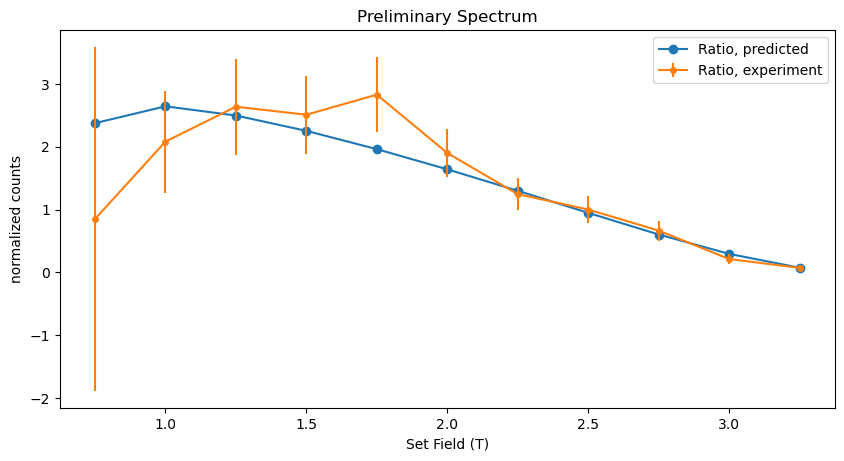

In [109]:
C = result.params["C"].value
ratio_obs["Ratio"] = C*ratio_obs["Ratio"]

fig0, ax0 = plt.subplots(figsize=(10,5))
plot_predicted_ratio(ratio_pred, ax0 )
plot_experimental_ratio(ratio_obs, ax0 )

ax0.set_ylabel('normalized counts')
ax0.set_xlabel('Set Field (T)')
ax0.set_title("Preliminary Spectrum")
ax0.legend()

In [100]:
result1 = minimize(objfunc, my_pars, method='nelder')
result1.params['decay'].vary = True
result2 = minimize(objfunc, result1.params, method='leastsq')

NameError: name 'objfunc' is not defined

In [22]:
# Select cuts. 
cuts = {"EventStartFreq": (100*1e6, 1200e6), "EventNBins": (100, np.inf), "mTotalSNR": (35, np.inf)}

# Make he and ne spectra dfs
cut = 8
ne = re.build_spectrum(snr_study["ne"][cut].events, snr_study["ne"][cut].root_files, cuts)
he = re.build_spectrum(snr_study["he"][cut].events, snr_study["he"][cut].root_files, cuts)

print(ne["mon_adjusted_count"].sum())
print(he["mon_adjusted_count"].sum())

RangeIndex(start=0, stop=11, step=1)
RangeIndex(start=0, stop=11, step=1)
3932.7619791454026
7893.320360573134


[1.8075e+10 1.9100e+10]


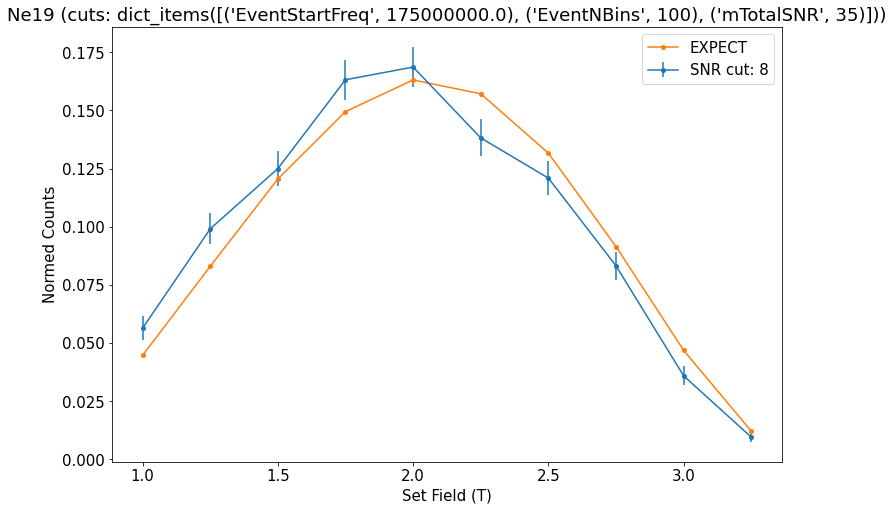

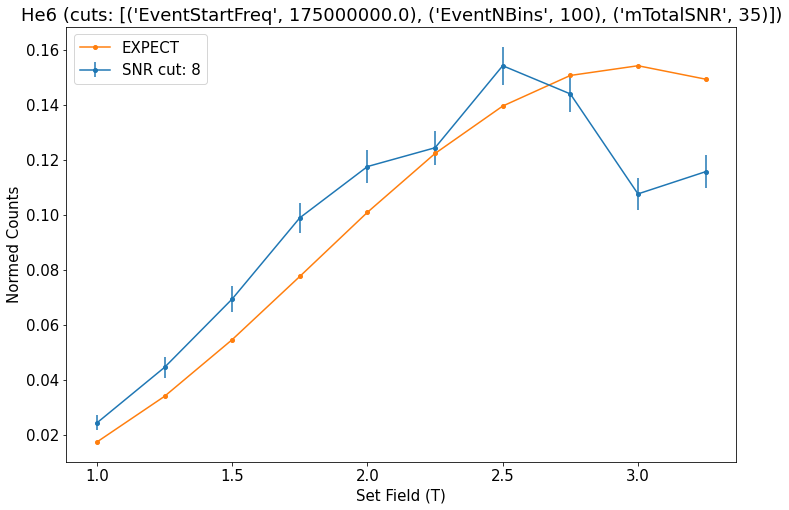

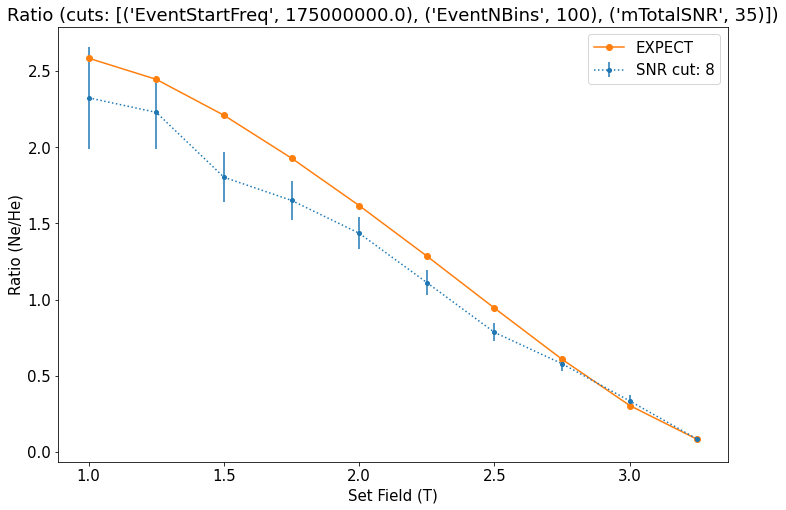

In [27]:
%matplotlib inline
plt.rcParams.update({'font.size': 15})
# fig0, ax0 = plt.subplots(figsize=(12,8))
# fig1, ax1 = plt.subplots(figsize=(12,8))
fig2, ax2 = plt.subplots(figsize=(12,8))
fig3, ax3 = plt.subplots(figsize=(12,8))
fig4, ax4 = plt.subplots(figsize=(12,8))

cut = 8
alt_cuts = {"EventStartFreq": 175e6, "EventNBins": 100, "mTotalSNR": 35}
ne_events = snr_study["ne"][cut].events
he_events = snr_study["he"][cut].events

ne_condition = ( (ne_events.EventStartFreq > alt_cuts["EventStartFreq"])
            & (ne_events.EventNBins > alt_cuts["EventNBins"])
            & (ne_events.mTotalSNR > alt_cuts["mTotalSNR"])
            & (ne_events.set_field > .75))

he_condition = ( (he_events.EventStartFreq > alt_cuts["EventStartFreq"])
            & (he_events.EventNBins > alt_cuts["EventNBins"])
            & (he_events.mTotalSNR > alt_cuts["mTotalSNR"])
            & (he_events.set_field > .75) )

ne_events_cut = ne_events[ne_condition]
he_events_cut = he_events[he_condition]

# Counts plots
ne_counts = ne_events_cut.groupby("set_field").run_id.count()
he_counts = he_events_cut.groupby("set_field").run_id.count()

# # print(ne_counts, he_counts)

# ax0.errorbar(ne_counts.index, ne_counts.values, yerr = (ne_counts.values)**.5, label = f"SNR cut: {cut}", marker='o', ms=4)
# ax1.errorbar(he_counts.index, he_counts.values, yerr = (he_counts.values)**.5, label = f"SNR cut: {cut}", marker='o', ms=4)

# Normed counts plots
ne_counts_norm = ne_counts / ne_counts.sum()
he_counts_norm = he_counts / he_counts.sum()
ne_err = (ne_counts)**.5/ ne_counts.sum()
he_err = (he_counts)**.5/ he_counts.sum()

ax2.errorbar(ne_counts_norm.index, ne_counts_norm.values, yerr = ne_err.values, label = f"SNR cut: {cut}", marker='o', ms=4)
ax3.errorbar(he_counts_norm.index, he_counts_norm.values, yerr = he_err.values, label = f"SNR cut: {cut}", marker='o', ms=4)

# Ratio plot 
ratio = (ne_counts_norm/he_counts_norm).fillna(0)
ratio_err = ratio*(1/ne_counts + 1/he_counts)**.5
# print(ratio, ratio_err)
ratio_err = ratio_err.fillna(0)

ax4.errorbar(ratio.index, ratio.values, yerr = ratio_err.values, label = f"SNR cut: {cut}", marker='o',ls = 'dotted', ms=4)

## PREDICTION FOR RATIO PLOT. Taking this out for now.
# WHY DOES THIS SEEM TO BE SO DIFFERENT THAN LAST TIME. 
    
set_fields = np.arange(1.0,3.3,.25)
freq_BW = np.array([alt_cuts["EventStartFreq"]+ 17.9e9, 19.1e9])
print(freq_BW)
freq_BWs = np.tile(freq_BW, (len(set_fields), 1))

rates = AUC_expectation(set_fields, freq_BWs, b = 0, plot = False)

ax2.plot(rates.index, rates.Ne19, label = f"EXPECT", marker='o', ms=4)
ax3.plot(rates.index, rates.He6, label = f"EXPECT", marker='o', ms=4)

ax4.plot(rates.index, rates.ratio,  label = f"EXPECT", marker='o', ms=6)
    

# # ax.set_yscale("log")
# ax0.set_title(f"Ne19 (cuts: {alt_cuts.items()})")
# ax0.set_xlabel('Set Field (T)')
# ax0.set_ylabel('Total Counts')
# ax0.legend()

# ax1.set_title(f"He6 (cuts: {list(alt_cuts.items())})")
# ax1.set_xlabel('Set Field (T)')
# ax1.set_ylabel('Total Counts')
# ax1.legend()

ax2.set_title(f"Ne19 (cuts: {alt_cuts.items()})")
ax2.set_xlabel('Set Field (T)')
ax2.set_ylabel('Normed Counts')
ax2.legend()

ax3.set_title(f"He6 (cuts: {list(alt_cuts.items())})")
ax3.set_xlabel('Set Field (T)')
ax3.set_ylabel('Normed Counts')
ax3.legend()

ax4.set_title(f"Ratio (cuts: {list(alt_cuts.items())})")
ax4.set_xlabel('Set Field (T)')
ax4.set_ylabel('Ratio (Ne/He)')
ax4.legend()

plt.show()

## Look through the below for clues on what is causing these issues. 

* He: 
    * 1.0 T seems like an issue. 

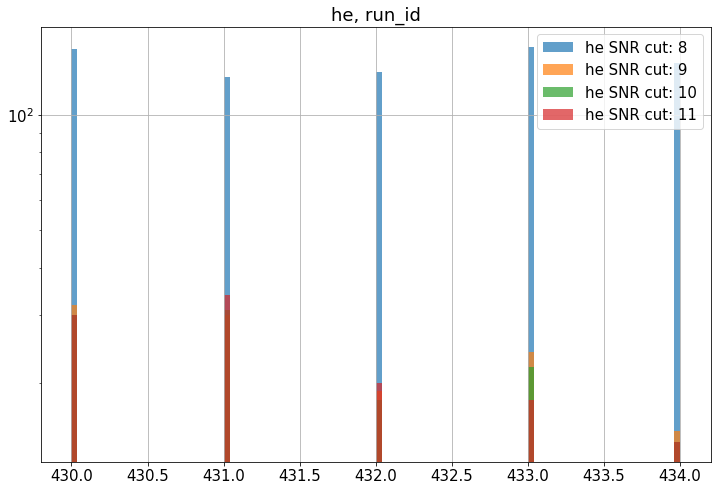

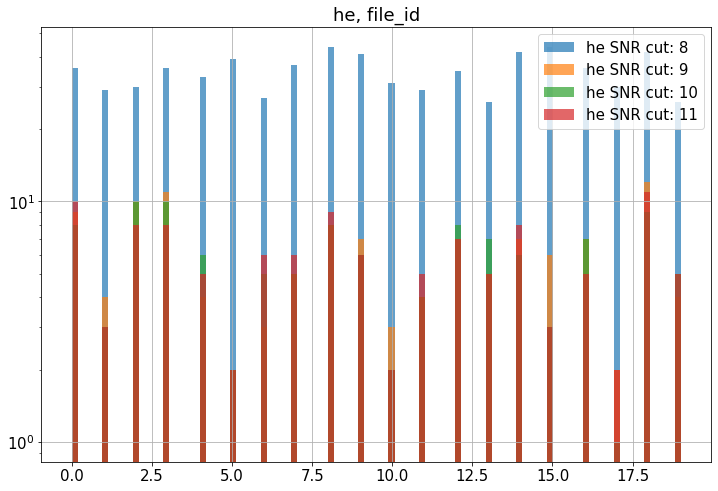

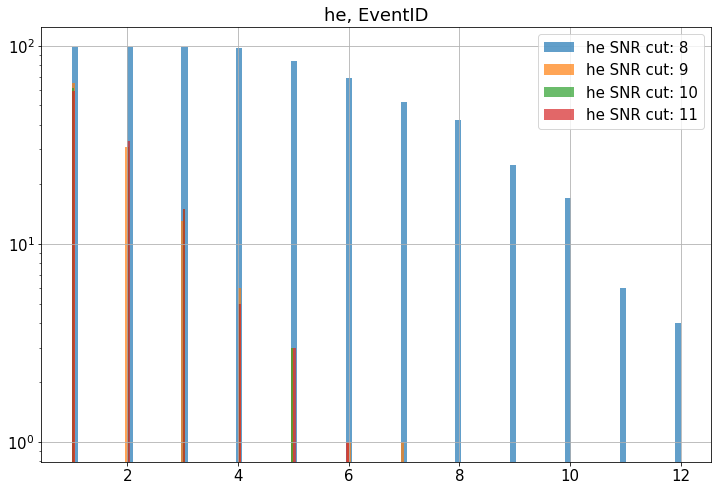

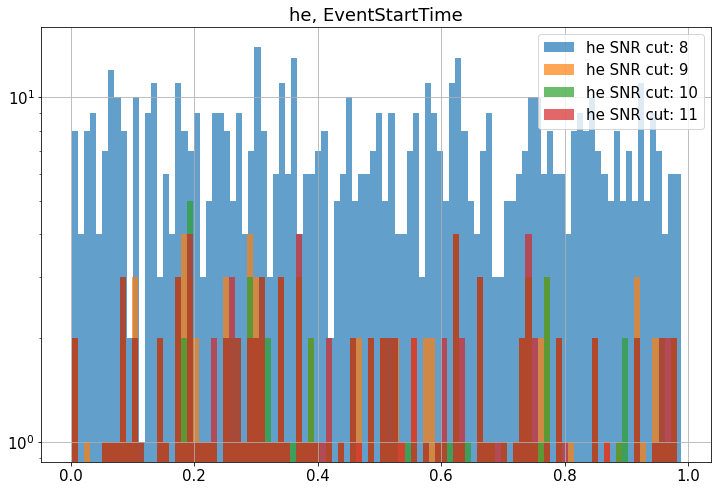

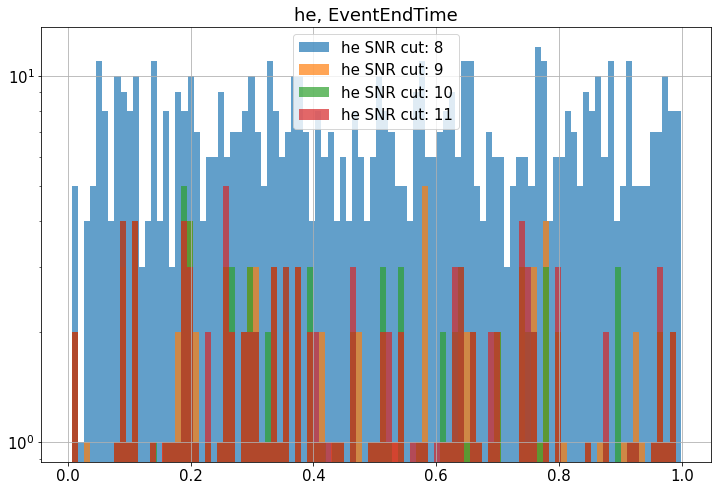

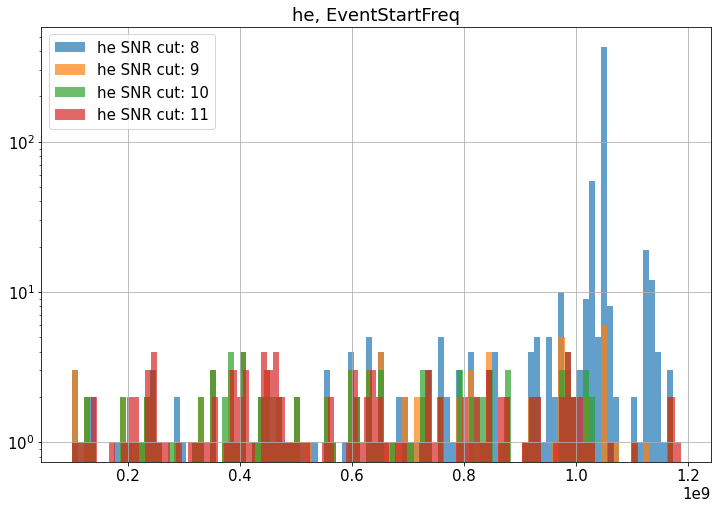

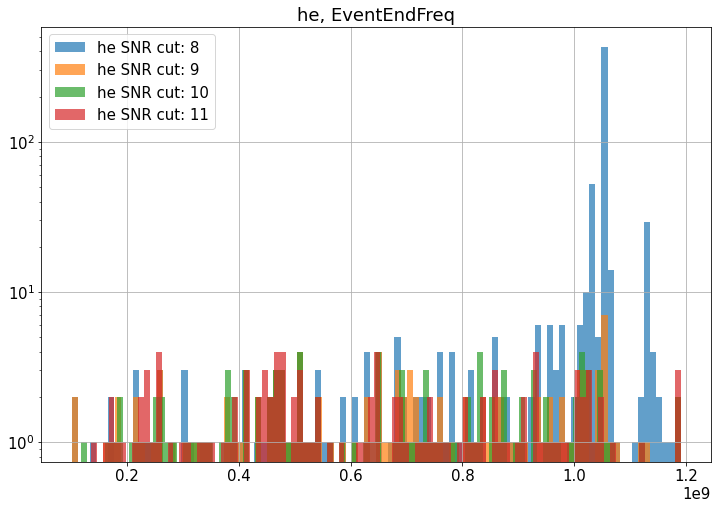

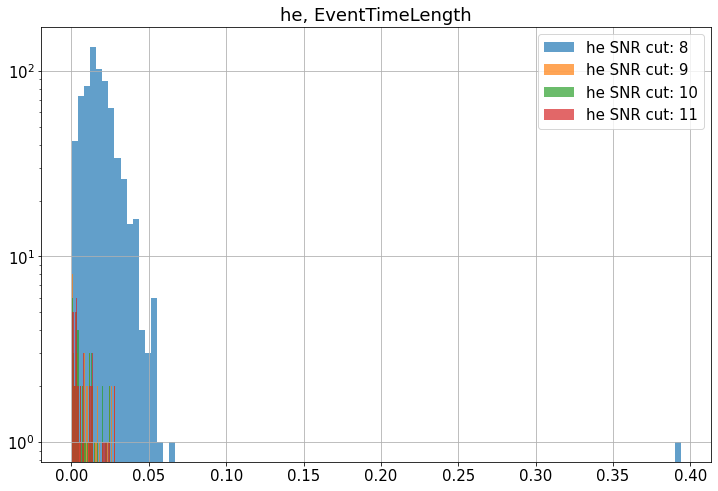

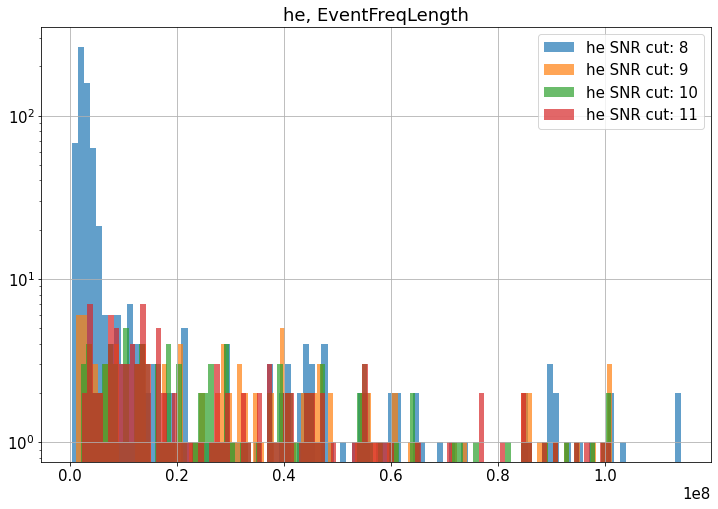

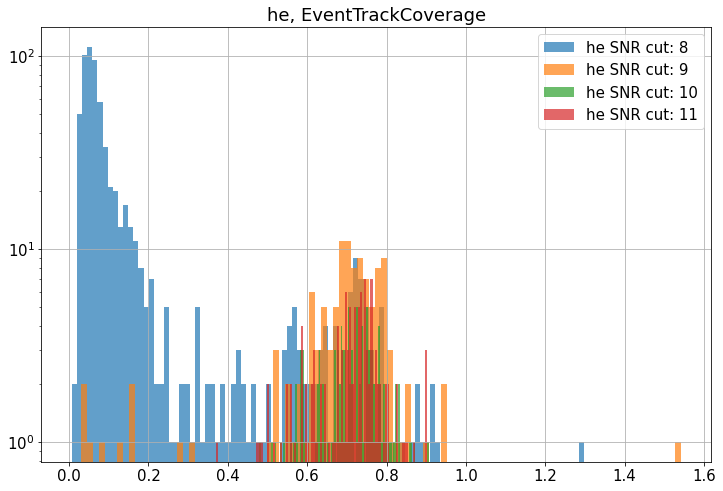

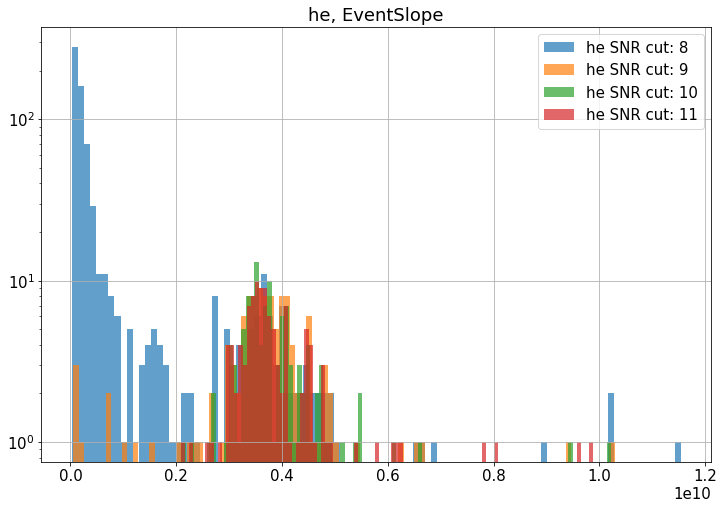

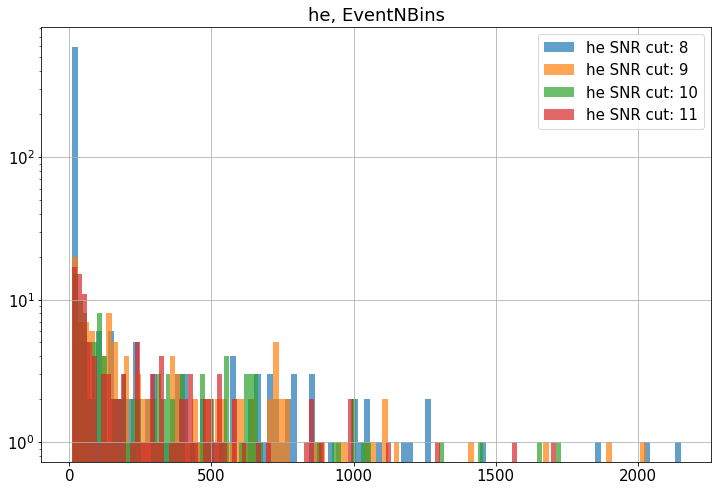

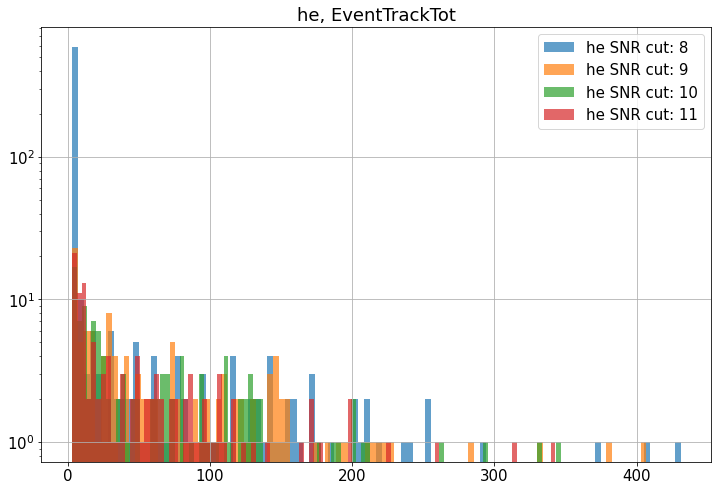

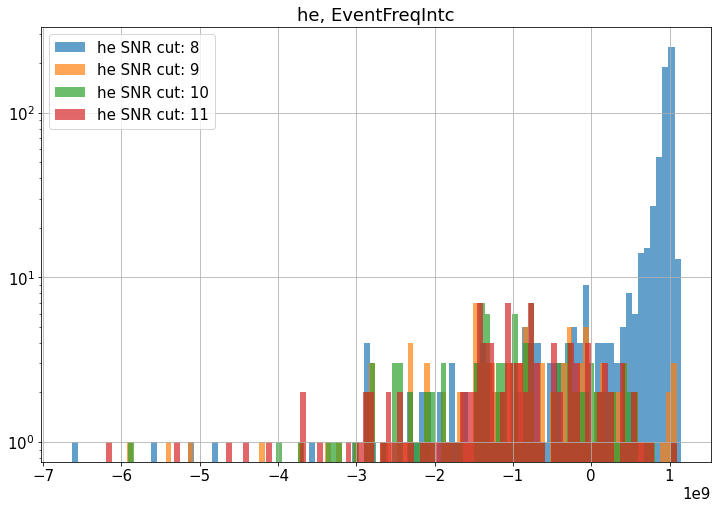

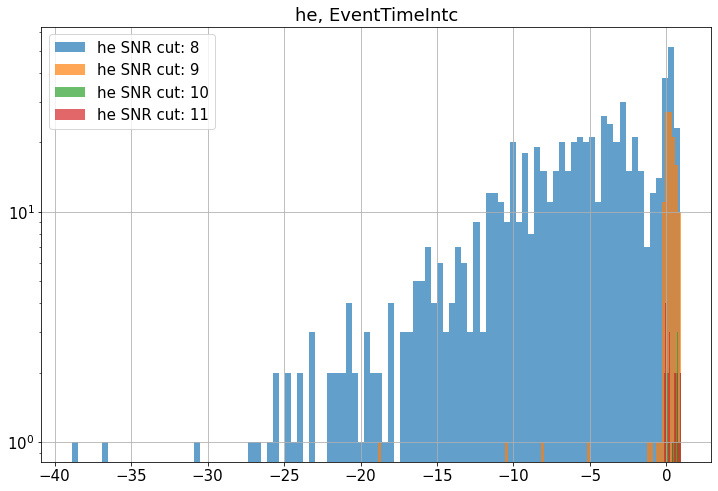

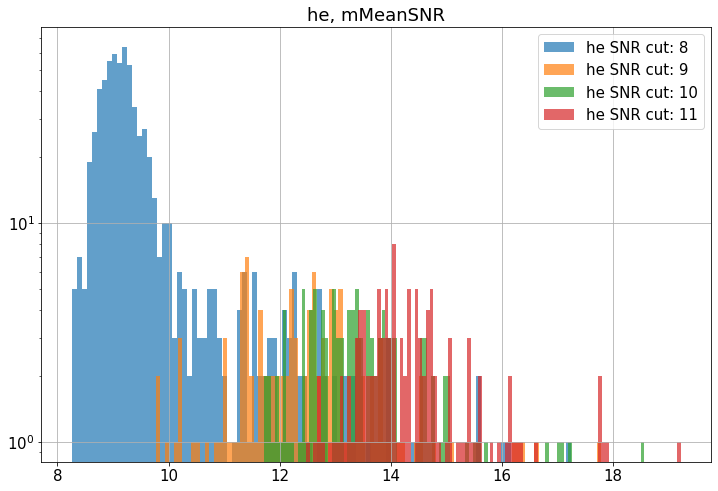

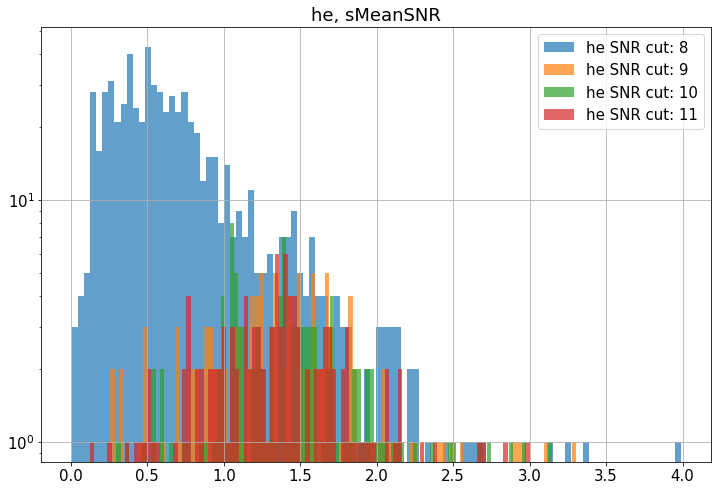

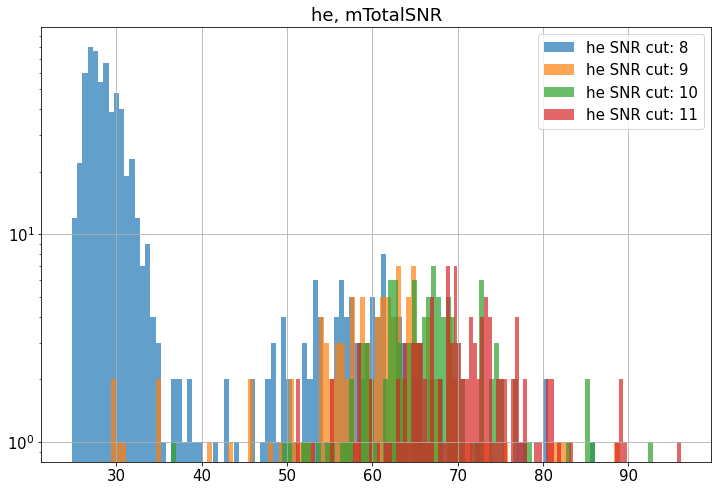

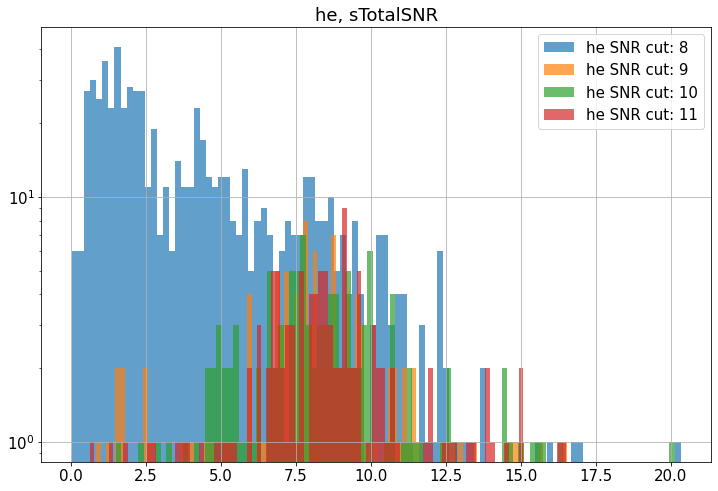

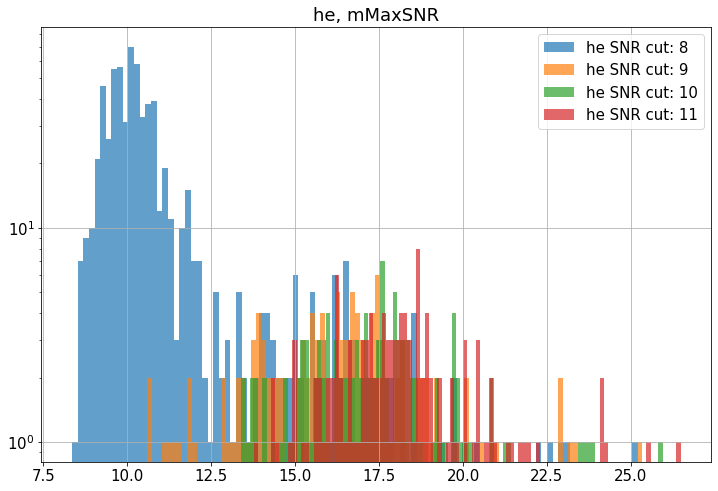

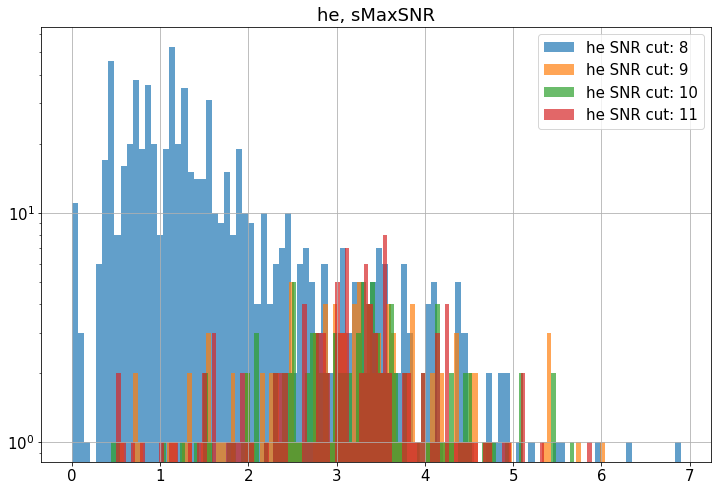

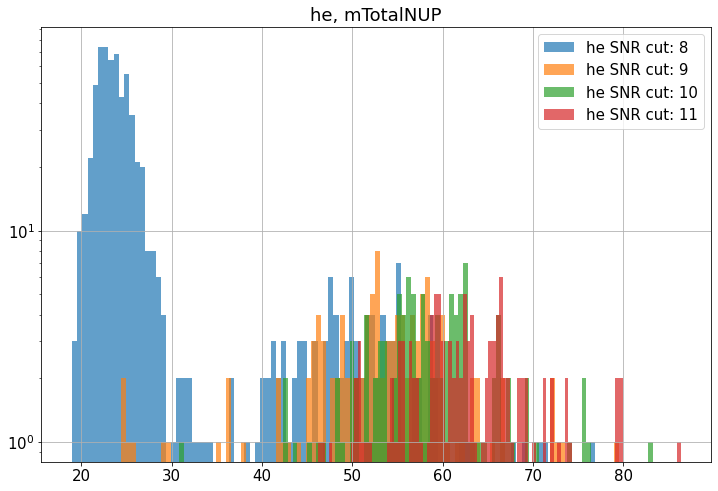

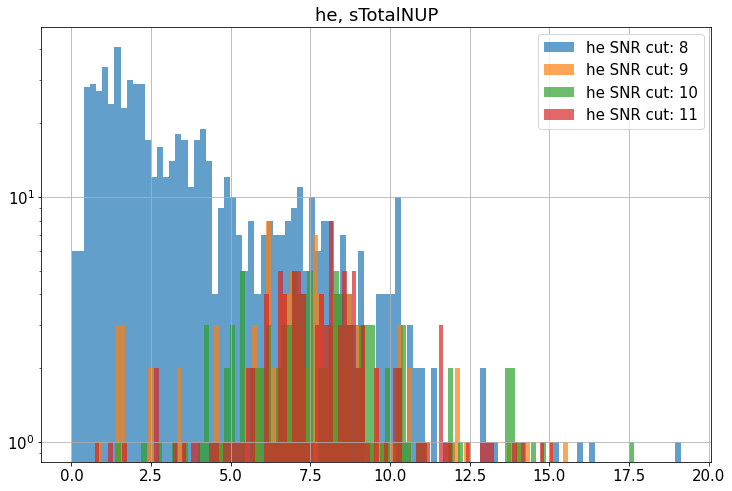

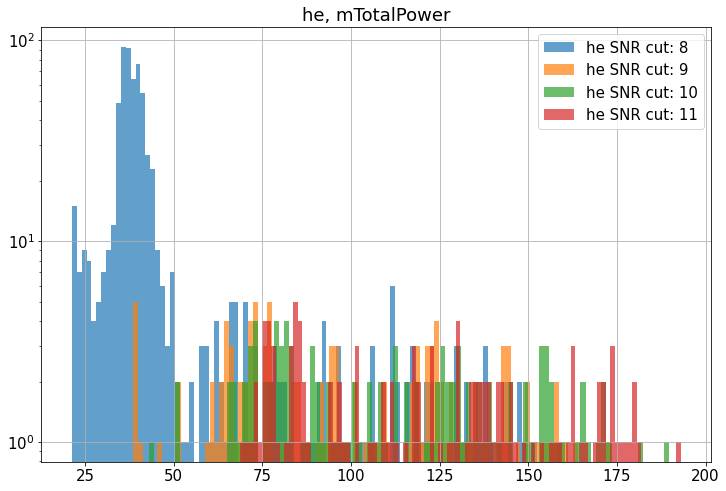

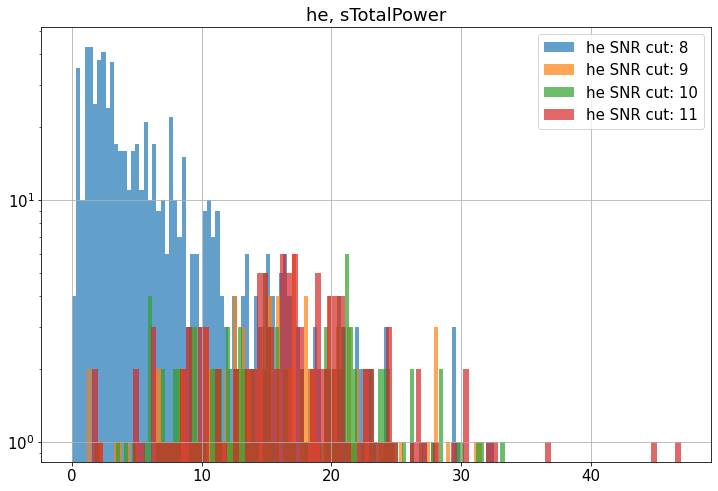

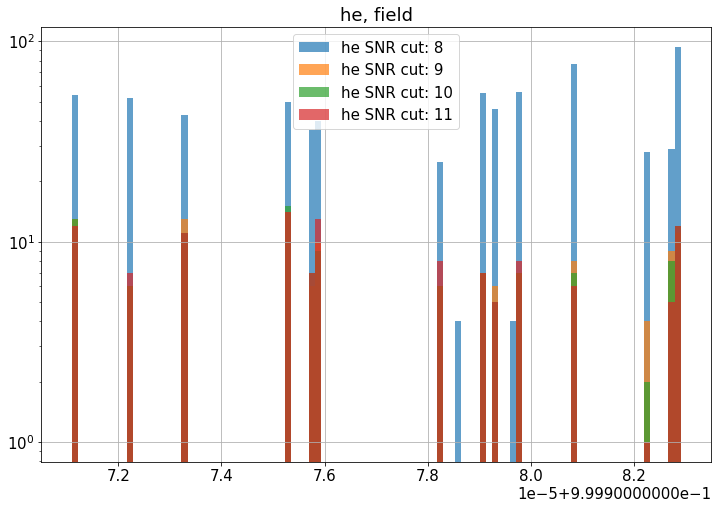

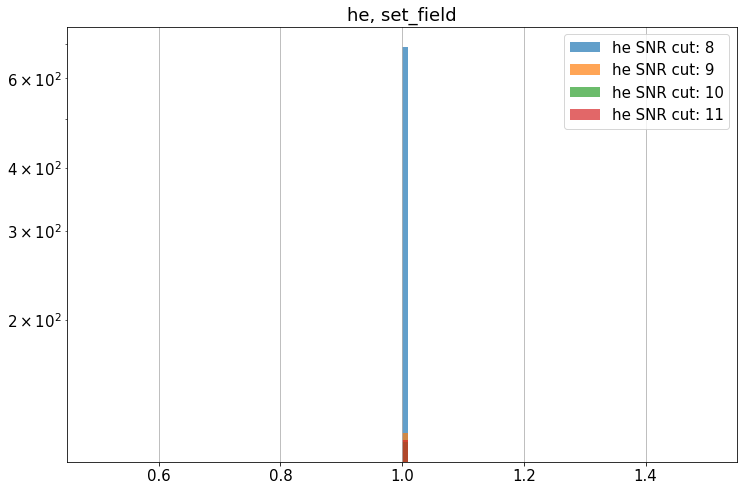

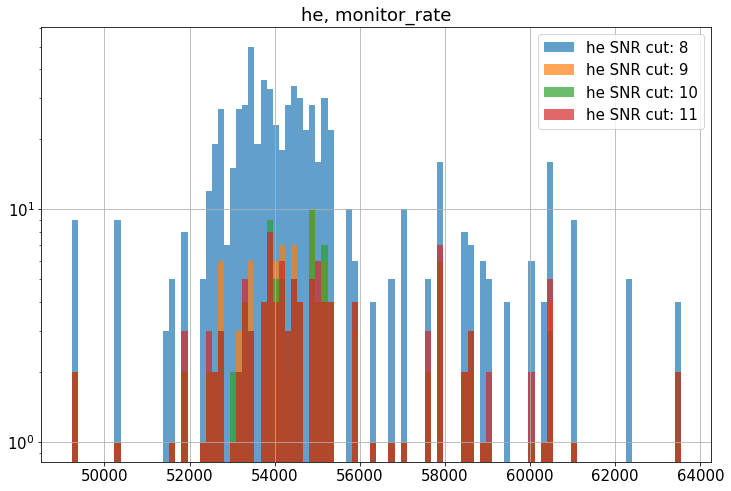

In [148]:
%matplotlib inline
plt.rcParams.update({'font.size': 15})

alt_cuts = {"EventStartFreq": 0, "EventNBins": 0, "mTotalSNR": 0}
isotope = "he"

# for column in ['EventSlope', 'EventNBins','mMeanSNR', 'sMeanSNR', 'mTotalSNR',
#        'sTotalSNR', 'mMaxSNR', 'sMaxSNR', 'mTotalNUP', 'sTotalNUP',
#        'mTotalPower', 'sTotalPower']:
for column in snr_study[isotope][cut].events.columns:
    fig, ax = plt.subplots(figsize=(12,8))
    for cut in snr_cuts[1:]: 
        events = snr_study[isotope][cut].events

        condition = ( (events.EventStartFreq > alt_cuts["EventStartFreq"])
                    & (events.EventNBins > alt_cuts["EventNBins"])
                    & (events.mTotalSNR > alt_cuts["mTotalSNR"])
                    & (events.set_field == 1.0)
                    & (events.EventTimeIntc > -50))

        events_cut = events[condition]
    
        density = False
        
        events_cut.hist(column = column, bins = 100, density = density,  alpha = .7, ax = ax, label = f"{isotope} SNR cut: {cut}")

    plt.title(f"{isotope}, {column}")
    ax.set_yscale("log")
    # plt.title(f"He6, {column}")
    plt.legend()

    plt.show()

In [29]:
snr_study["he"][7].events.shape[0]

265285

In [ ]:
snr_study["he"][7].events.shape[0]

In [5]:
                ( (events.EventStartFreq > 200e6)
                & (events.EventNBins > 100)
                & (events.mTotalSNR > 35))
names_list = ["snr7","snr9", "snr11" ]

ne_results_list = [ne_snr7, ne_snr9,  ne_snr11]
ne_events_list = [result.events for result in ne_results_list]

In [6]:
he_results_list = [he_snr7, he_snr9, he_snr11]
# names_list = ["snr9", "snr11" ]
he_events_list = [result.events for result in he_results_list]

In [7]:
print(len(ne_events_list), len(he_events_list))

3 3


In [11]:
ne_events_list[0].columns

Index(['run_id', 'file_id', 'EventID', 'EventStartTime', 'EventEndTime',
       'EventStartFreq', 'EventEndFreq', 'EventTimeLength', 'EventFreqLength',
       'EventTrackCoverage', 'EventSlope', 'EventNBins', 'EventTrackTot',
       'EventFreqIntc', 'EventTimeIntc', 'mMeanSNR', 'sMeanSNR', 'mTotalSNR',
       'sTotalSNR', 'mMaxSNR', 'sMaxSNR', 'mTotalNUP', 'sTotalNUP',
       'mTotalPower', 'sTotalPower', 'field', 'set_field', 'monitor_rate'],
      dtype='object')

## Plot total events observed vs field for the three tests: 

2345
1928
1486


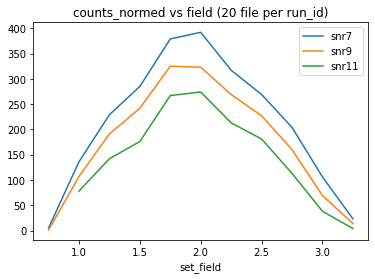

In [15]:
%matplotlib inline

cuts = {200e6, 100, 35}
for i,events in enumerate(ne_events_list): 
    # Impose SNR Cut and stuff: 
    condition = ( (events.EventStartFreq > 200e6)
                & (events.EventNBins > 100)
                & (events.mTotalSNR > 35))
    events = events[condition]
    counts = events.groupby("set_field").run_id.count() 
    counts_normed = counts 
    print(counts.sum())
    counts_normed.plot(label = names_list[i]) 
    # counts.plot(label = names_list[i])
    # print(events.groupby("set_field").run_id.count())
    
plt.title("counts_normed vs field (20 file per run_id)")
plt.legend()
plt.show()

2138
2877
2452


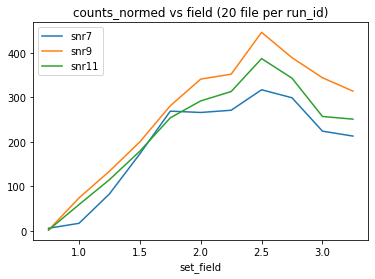

In [16]:
for i,events in enumerate(he_events_list): 
    # Impose SNR Cut and stuff: 
    condition = ( (events.EventStartFreq > 200e6)
                & (events.EventNBins > 100)
                & (events.mTotalSNR > 35))
    events = events[condition]
    counts = events.groupby("set_field").run_id.count() 
    counts_normed = counts 
    print(counts.sum())
    counts_normed.plot(label = names_list[i]) 
    # counts.plot(label = names_list[i])
    # print(events.groupby("set_field").run_id.count())
    
plt.title("counts_normed vs field (20 file per run_id)")
plt.legend()
plt.show()

In [ ]:
## 

0
2345 2138
1
1928 2877
2
1486 2452


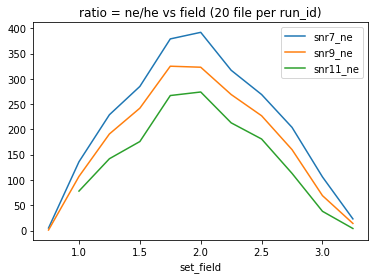

In [14]:
%matplotlib inline
for i,(ne_events, he_events) in enumerate(zip(ne_events_list, he_events_list)):
    print(i)
                                          
    # Impose SNR Cut and stuff: 
    ne_condition = ( (ne_events.EventStartFreq >200e6)
                & (ne_events.EventNBins > 100)
                & (ne_events.mTotalSNR > 35))
    he_condition = ( (he_events.EventStartFreq > 200e6)
                & (he_events.EventNBins > 100)
                & (he_events.mTotalSNR > 35))
                                          
    ne_events_cut = ne_events[ne_condition]
    he_events_cut = he_events[he_condition]
    
    ne_counts = ne_events_cut.groupby("set_field").run_id.count()
    he_counts = he_events_cut.groupby("set_field").run_id.count()
    print(ne_counts.sum(), he_counts.sum())
    
    ne_counts_normed = ne_counts / ne_counts.sum()
    he_counts_normed = he_counts / he_counts.sum()
    
    ratio = ne_counts_normed/he_counts_normed
    # print(ratio)
    # print(counts.sum())
    # counts_normed.plot(label = names_list[i]) 
    ne_counts.plot(label = f"{names_list[i]}_ne")
    # he_counts.plot(label = f"{names_list[i]}_he")
    # ratio.plot(label = names_list[i])
    # print(events.groupby("set_field").run_id.count())
    
plt.title("ratio = ne/he vs field (20 file per run_id)")
plt.legend()
plt.show()

# Notes: 

* snr7 works for ne, not for he. Why is that? 
* 

In [38]:
ne_events_list[0].columns

Index(['run_id', 'file_id', 'EventID', 'EventStartTime', 'EventEndTime',
       'EventStartFreq', 'EventEndFreq', 'EventTimeLength', 'EventFreqLength',
       'EventTrackCoverage', 'EventSlope', 'EventNBins', 'EventTrackTot',
       'EventFreqIntc', 'EventTimeIntc', 'mMeanSNR', 'sMeanSNR', 'mTotalSNR',
       'sTotalSNR', 'mMaxSNR', 'sMaxSNR', 'mTotalNUP', 'sTotalNUP',
       'mTotalPower', 'sTotalPower', 'field', 'set_field', 'monitor_rate'],
      dtype='object')

ne snr7 EventSlope mean:  47376114836.211685
he snr7 EventSlope mean:  49421308614.71538


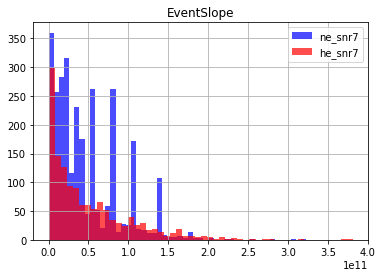

ne snr9 EventSlope mean:  48088093873.3103
he snr9 EventSlope mean:  86757088442.45169


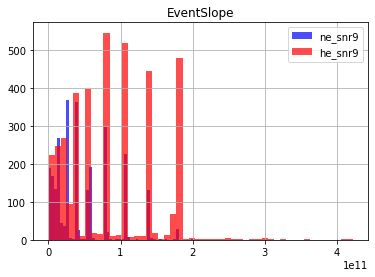

ne snr7 EventNBins mean:  395.531746031746
he snr7 EventNBins mean:  632.9639970609845


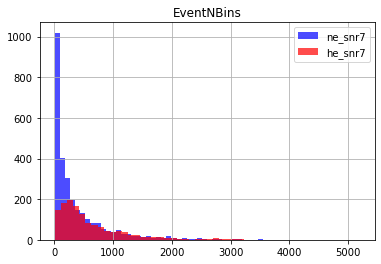

ne snr9 EventNBins mean:  291.54719101123595
he snr9 EventNBins mean:  290.64040561622465


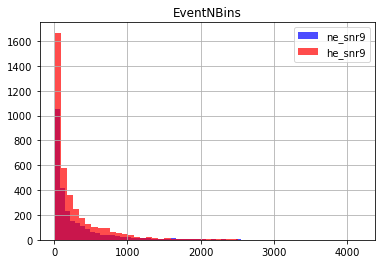

ne snr7 mMeanSNR mean:  10.41230313402878
he snr7 mMeanSNR mean:  10.689336777834086


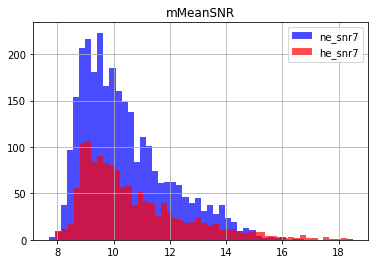

ne snr9 mMeanSNR mean:  12.484938527898999
he snr9 mMeanSNR mean:  12.772339478254208


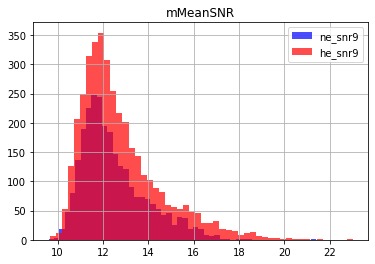

ne snr7 sMeanSNR mean:  1.559301172514843
he snr7 sMeanSNR mean:  2.2230427716681427


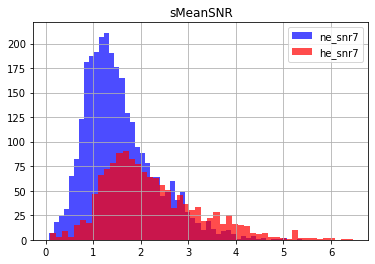

ne snr9 sMeanSNR mean:  1.520748988917252
he snr9 sMeanSNR mean:  1.6435745585593824


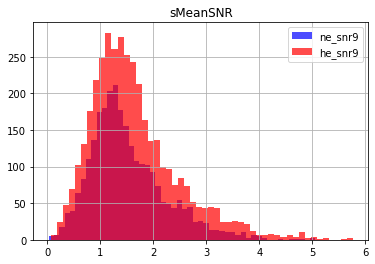

ne snr7 mTotalSNR mean:  50.196428575165875
he snr7 mTotalSNR mean:  48.7823162498529


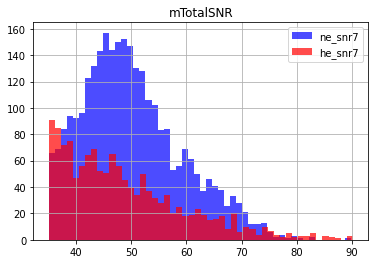

ne snr9 mTotalSNR mean:  60.731720675244965
he snr9 mTotalSNR mean:  61.65183168970575


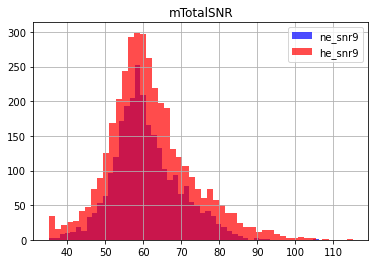

ne snr7 sTotalSNR mean:  10.144004911330274
he snr7 sTotalSNR mean:  15.951779434181423


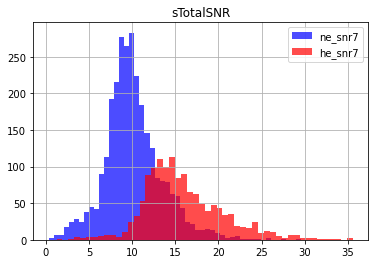

ne snr9 sTotalSNR mean:  9.496519840287725
he snr9 sTotalSNR mean:  10.351470196188293


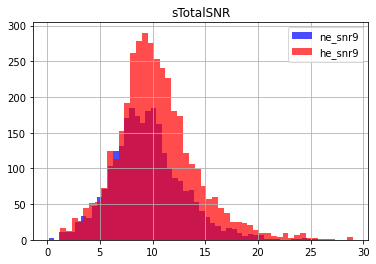

ne snr7 mMaxSNR mean:  14.05798520685846
he snr7 mMaxSNR mean:  14.487106997602577


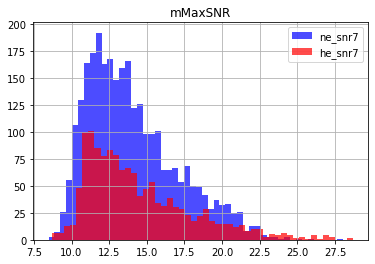

ne snr9 mMaxSNR mean:  16.244832913522156
he snr9 mMaxSNR mean:  16.786867079980333


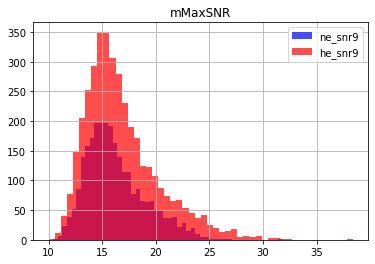

ne snr7 sMaxSNR mean:  3.4249090042409924
he snr7 sMaxSNR mean:  4.697327431663487


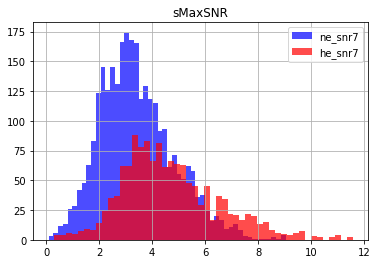

ne snr9 sMaxSNR mean:  3.3442911720138464
he snr9 sMaxSNR mean:  3.609848610103891


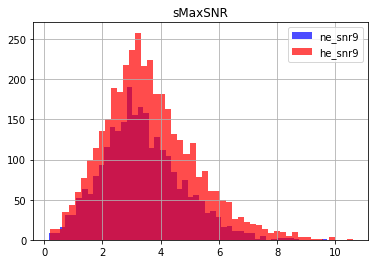

ne snr7 mTotalNUP mean:  43.29965829197679
he snr7 mTotalNUP mean:  41.33486340418943


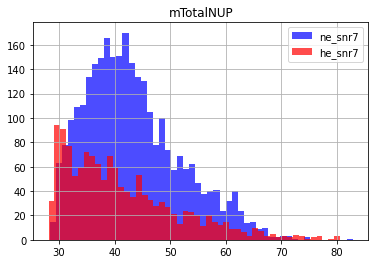

ne snr9 mTotalNUP mean:  53.329491018253776
he snr9 mTotalNUP mean:  53.081275978443344


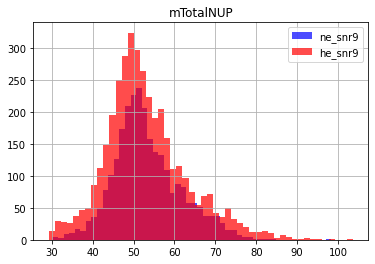

ne snr7 sTotalNUP mean:  9.380848436786057
he snr7 sTotalNUP mean:  14.3506236769911


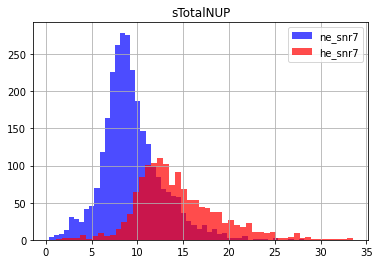

ne snr9 sTotalNUP mean:  8.902432449326222
he snr9 sTotalNUP mean:  9.569337773258264


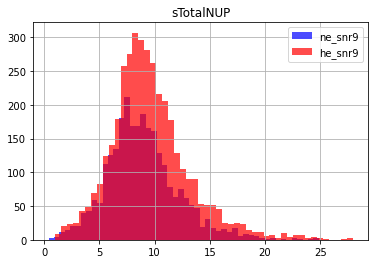

ne snr7 mTotalPower mean:  86.95768277620104
he snr7 mTotalPower mean:  66.16572574828218


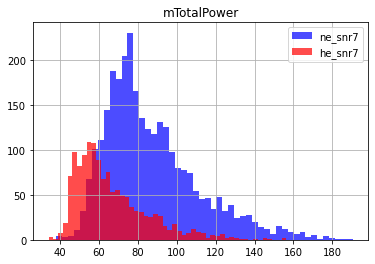

ne snr9 mTotalPower mean:  106.47773758862711
he snr9 mTotalPower mean:  85.01839664943091


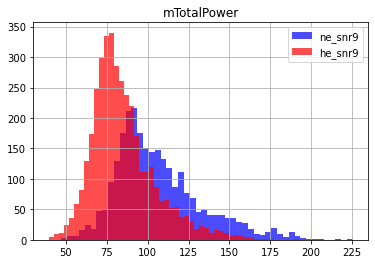

ne snr7 sTotalPower mean:  23.85175208996831
he snr7 sTotalPower mean:  25.337372584622994


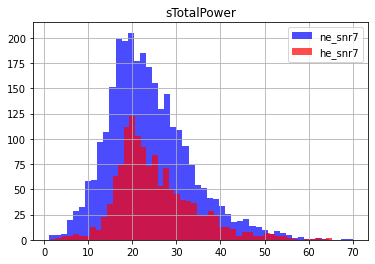

ne snr9 sTotalPower mean:  25.34162879411941
he snr9 sTotalPower mean:  20.33945148222878


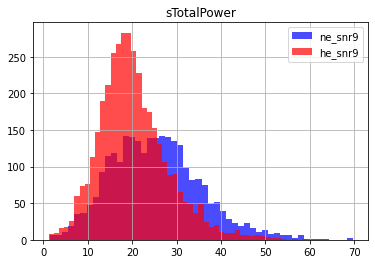

In [12]:
%matplotlib inline

# for column in events_list[0].columns:
for column in ['EventSlope', 'EventNBins','mMeanSNR', 'sMeanSNR', 'mTotalSNR',
       'sTotalSNR', 'mMaxSNR', 'sMaxSNR', 'mTotalNUP', 'sTotalNUP',
       'mTotalPower', 'sTotalPower']:
    for i,(ne_events, he_events) in enumerate(zip(ne_events_list, he_events_list)): 
            # Impose SNR Cut and stuff: 
        if i >1: break
        # cuts = (100
        ne_condition = ( (ne_events.EventStartFreq >350e6)
                    & (ne_events.EventNBins > 0)
                    & (ne_events.mTotalSNR > 35))
        he_condition = ( (he_events.EventStartFreq > 350e6)
                    & (he_events.EventNBins > 0)
                    & (he_events.mTotalSNR > 35))

        ne_events_cut = ne_events[ne_condition]
        he_events_cut = he_events[he_condition]
        # events = events[events.EventStartFreq < 1100e6]
        print("ne", names_list[i],column, "mean: ", ne_events_cut[column].mean())
        print("he", names_list[i],column, "mean: ", he_events_cut[column].mean())
        fig, ax = plt.subplots()
        density = False
        
        ne_events_cut.hist(column = column, bins = 50, density = density,  alpha = .7, color = 'b', ax = ax, label = f"ne_{names_list[i]}")
        he_events_cut.hist(column = column, bins = 50, density = density, alpha = .7, color = 'r', ax = ax, label = f"he_{names_list[i]}")
        plt.legend()
                
        plt.show()
        

In [5]:
exp_results_demo.root_files.head(3)

,run_id,spec_id,file_path,true_field,analysis_id,root_file_exists,file_id,rocks_file_path,exists,approx_slope,...,base_config_path,output_dir,noise_file_path,rocks_noise_file_path,root_file_path,pst_time,utc_time,monitor_rate,field,set_field
0,561,17672,/mnt/sdb/data/Freq_data_2022-10-06-18-52-37.spec,0.750168,2,True,0,/data/eliza4/he6_cres/sdb/data/Freq_data_2022-...,True,5.127943e+08,...,/data/eliza4/he6_cres/katydid_analysis/base_co...,/data/eliza4/he6_cres/katydid_analysis/root_fi...,/mnt/sdb/data/Freq_data_2022-10-06-19-02-08.spec,/data/eliza4/he6_cres/sdb/data/Freq_data_2022-...,/data/eliza4/he6_cres/katydid_analysis/root_fi...,2022-10-06 18:52:37-07:00,2022-10-07 01:52:37+00:00,11821.82,0.750168,0.75
1,561,17673,/mnt/sdc/data/Freq_data_2022-10-06-18-52-41.spec,0.750168,2,True,1,/data/eliza4/he6_cres/sdc/data/Freq_data_2022-...,True,5.127943e+08,...,/data/eliza4/he6_cres/katydid_analysis/base_co...,/data/eliza4/he6_cres/katydid_analysis/root_fi...,/mnt/sdb/data/Freq_data_2022-10-06-19-02-08.spec,/data/eliza4/he6_cres/sdb/data/Freq_data_2022-...,/data/eliza4/he6_cres/katydid_analysis/root_fi...,2022-10-06 18:52:41-07:00,2022-10-07 01:52:41+00:00,11751.75,0.750168,0.75
2,561,17674,/mnt/sdd/data/Freq_data_2022-10-06-18-52-44.spec,0.750168,2,True,2,/data/eliza4/he6_cres/sdd/data/Freq_data_2022-...,True,5.127943e+08,...,/data/eliza4/he6_cres/katydid_analysis/base_co...,/data/eliza4/he6_cres/katydid_analysis/root_fi...,/mnt/sdb/data/Freq_data_2022-10-06-19-02-08.spec,/data/eliza4/he6_cres/sdb/data/Freq_data_2022-...,/data/eliza4/he6_cres/katydid_analysis/root_fi...,2022-10-06 18:52:44-07:00,2022-10-07 01:52:44+00:00,12100.00,0.750168,0.75


In [6]:
exp_results_demo.tracks.head(3)

,run_id,file_id,root_file_path,field,monitor_rate,UniqueID,Bits,Component,AcquisitionID,TrackID,...,FreqIntc,TimeIntc,MeanTrackSNR,set_field,TimeIntc_mean,TimeIntc_std,TimeLength_mean,TimeLength_std,Slope_mean,Slope_std
0,557,0,/data/eliza4/he6_cres/katydid_analysis/root_fi...,0.750156,12070.0,0.0,50331648.0,0.0,0.0,56.0,...,6.207404e+08,-0.473662,13.336956,0.75,-0.575314,0.065353,0.000311,0.000022,1.108192e+09,1.204435e+08
1,557,0,/data/eliza4/he6_cres/katydid_analysis/root_fi...,0.750156,12070.0,0.0,50331648.0,0.0,0.0,58.0,...,6.354270e+08,-0.617951,12.575068,0.75,-0.575314,0.065353,0.000311,0.000022,1.108192e+09,1.204435e+08
2,557,0,/data/eliza4/he6_cres/katydid_analysis/root_fi...,0.750156,12070.0,0.0,50331648.0,0.0,0.0,59.0,...,6.388116e+08,-0.663283,11.505167,0.75,-0.575314,0.065353,0.000311,0.000022,1.108192e+09,1.204435e+08


In [7]:
exp_results_demo.events.head(3)

,run_id,file_id,EventID,EventStartTime,EventEndTime,EventStartFreq,EventEndFreq,EventTimeLength,EventFreqLength,EventTrackCoverage,EventMeanSNR,EventSlope,EventNBins,EventTrackTot,EventFreqIntc,EventTimeIntc,field,set_field,monitor_rate
0,492,0,1,0.183586,0.187259,2.520657e+08,9.088147e+08,0.003673,6.567489e+08,0.907063,11.619695,1.788168e+11,146.0,30,-3.257623e+10,0.182177,3.250452,3.25,13773.77
1,494,0,1,0.869270,0.874110,3.175379e+08,1.179350e+09,0.004840,8.618117e+08,0.891396,11.824411,1.780563e+11,211.0,43,-1.544615e+11,0.867487,3.250472,3.25,12920.00
2,500,0,1,0.407494,0.415324,1.127912e+08,1.199735e+09,0.007830,1.086943e+09,0.985179,13.548446,1.388145e+11,658.0,133,-5.645328e+10,0.406681,3.000424,3.00,11710.00


## Are all the desired fields present?

In [5]:
len(exp_results_demo.run_ids)

57

In [10]:
exp_results_demo.events.groupby([ "set_field"]).run_id.unique().reset_index()

,set_field,run_id
0,0.75,"[557, 559, 560, 558, 561]"
1,1.00,"[551, 552, 553, 554, 555]"
2,1.25,"[542, 543, 544, 545, 546]"
3,1.50,"[536, 537, 538, 539, 540]"
4,1.75,"[530, 531, 532, 533, 534]"
5,2.00,"[524, 525, 526, 527, 528]"
6,2.25,"[518, 519, 520, 521]"
7,2.50,"[512, 513, 514, 515, 516]"
8,2.75,"[506, 507, 508, 509, 510]"
9,3.00,"[500, 501, 502, 503, 504]"


### 2c: Visualize the quality of track and event reconstruction.

In [8]:
exp_results_demo.tracks.columns

Index(['run_id', 'file_id', 'root_file_path', 'field', 'monitor_rate',
       'UniqueID', 'Bits', 'Component', 'AcquisitionID', 'TrackID', 'EventID',
       'EventSequenceID', 'IsCut', 'StartTimeInRunC', 'StartTimeInAcq',
       'EndTimeInRunC', 'TimeLength', 'StartFrequency', 'EndFrequency',
       'FrequencyWidth', 'Slope', 'SlopeChange', 'Intercept', 'TotalPower',
       'NTrackBins', 'TotalTrackSNR', 'MaxTrackSNR', 'TotalTrackNUP',
       'MaxTrackNUP', 'TotalWideTrackSNR', 'TotalWideTrackNUP',
       'StartTimeInRunCSigma', 'EndTimeInRunCSigma', 'TimeLengthSigma',
       'StartFrequencySigma', 'EndFrequencySigma', 'FrequencyWidthSigma',
       'SlopeSigma', 'InterceptSigma', 'TotalPowerSigma', 'FreqIntc',
       'TimeIntc', 'MeanTrackSNR', 'set_field', 'TimeIntc_mean',
       'TimeIntc_std', 'TimeLength_mean', 'TimeLength_std', 'Slope_mean',
       'Slope_std'],
      dtype='object')

In [12]:
exp_results_demo.events.columns

Index(['run_id', 'file_id', 'EventID', 'EventStartTime', 'EventEndTime',
       'EventStartFreq', 'EventEndFreq', 'EventTimeLength', 'EventFreqLength',
       'EventTrackCoverage', 'EventSlope', 'EventNBins', 'EventTrackTot',
       'EventFreqIntc', 'EventTimeIntc', 'mMeanSNR', 'sMeanSNR', 'mTotalSNR',
       'sTotalSNR', 'mMaxSNR', 'sMaxSNR', 'mTotalNUP', 'sTotalNUP',
       'mTotalPower', 'sTotalPower', 'field', 'set_field', 'monitor_rate'],
      dtype='object')

In [44]:
isotope = "he"
exp_results_demo = snr_study[isotope][10]

In [49]:
# Impose SNR Cut and stuff: 
condition = ( (exp_results_demo.events.EventStartFreq > 100e6)
            & (exp_results_demo.events.EventNBins > 100))
exp_results_demo.events = exp_results_demo.events[condition]
    

## Use histograms to decide on cuts and then visualize what they do here: 

In [35]:
%matplotlib widget

plt.rcParams['figure.dpi']= 100

isotope = 'he'
@interact
def analysis_viz(
    run_id = widgets.Select(options = snr_study[isotope][9].run_ids, description='run_id: '),
    file_id = widgets.Select(options = snr_study[isotope][9].file_ids, description='file_id: '),
    events = widgets.Checkbox(True, description='events'),
    tracks = widgets.Checkbox(False, description='tracks'),
    sparse = widgets.Checkbox(False, description='sparse_spec'),
    EventID = widgets.IntSlider(value=1,min=1,max=20,step=1),
    mrk_sz = widgets.FloatSlider(value=.08,min=0,max=10.0,step=1e-1),
    event_alpha = widgets.FloatSlider(value=1.0,min=0.0,max=1.0,step=1e-2), 
    ss_alpha = widgets.FloatSlider(value=.3,min=0.0,max=1.0,step=1e-2),
    frac_pts = widgets.FloatSlider(value=.7,min=0.0,max=1.0,step=1e-2),
    isotope = widgets.Select(options = snr_study.keys() ,  description='isotope: ', value = 'he'),
    cut = widgets.Select(options = snr_cuts,  description='snr cut: ', value = 9)
):
    
    cuts = {"EventStartFreq": (100e6, 1200e6), "EventNBins": (100, np.inf), "mTotalSNR": (35, np.inf)}
    
    config = {"tracks": {"show": tracks,  "alpha": event_alpha, "EventIDs":[]}, 
              "events": {"show": events, "alpha": event_alpha, "cuts": cuts}, 
              "sparse_spec": {"show": sparse, "frac_pts": frac_pts,  "alpha": ss_alpha, "mrk_sz": mrk_sz}}
    
    
    snr_study[isotope][cut].visualize(run_id, file_id, config)


interactive(children=(Select(description='run_id: ', options=(373, 374, 375, 376, 377, 380, 382, 383, 384, 387…

### 2d: Visualize the relationship between different track attributes.

In [50]:
%matplotlib widget

set_fields = sorted(exp_results_demo.tracks['set_field'].unique().tolist())

plt.rcParams['figure.dpi']= 100
@interact
def scatter_plots(
    field = widgets.Select(options = set_fields,  description='set_field: '),
    column_1 = widgets.Select(options = exp_results_demo.tracks.columns,value = 'StartFrequency', description='x_col: '),
    column_2 = widgets.Select(options = exp_results_demo.tracks.columns,value = 'Slope', description='y_col: '),
    mrk_sz = widgets.FloatSlider(value=.4, min=0,max=1.0,step=1e-2),
    alpha = widgets.FloatSlider(value=.5, min=0.0,max=1.0,step=1e-2), 
    frac_pts = widgets.FloatSlider(value=0.02,min=0.0,max=1.0,step=1e-2), 
    bins = widgets.IntSlider(value=200,min=50,max=700,step=10),
    fix_field = widgets.Checkbox(
    value=False,
    description='fix field',
    disabled=False,
    indent=False
),
    isotope = widgets.Select(options = snr_study.keys() ,  description='isotope: '),
    cut = widgets.Select(options = snr_cuts,  description='snr cut: ')
):
    
    plt.close("all")
    scatt_settings={
            "figsize": (12, 4),
            "colors": ["b", "r", "g", "c", "m", "k"],
            "hist_bins": bins,
            "markersize": mrk_sz,
            "alpha": alpha,
        }
    snr_study[isotope][cut].scatter("tracks", column_1, column_2, fix_field = fix_field, field_value = field, scatt_settings = scatt_settings)

interactive(children=(Select(description='set_field: ', options=(0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2…

### 2e: Visualize the relationship between different event attributes.

* Add option to flip between isotopes. 

In [56]:
%matplotlib widget

set_fields = sorted(exp_results_demo.events['set_field'].unique().tolist())
snr_study["ne"][cut]
plt.rcParams['figure.dpi']= 100
@interact
def scatter_plots(
    field = widgets.Select(options = set_fields,  description='set_field: '),
    column_1 = widgets.Select(options = exp_results_demo.events.columns,value = 'EventStartTime', description='x_col: '),
    column_2 = widgets.Select(options = exp_results_demo.events.columns,value = 'EventStartFreq', description='y_col: '),
    mrk_sz = widgets.FloatSlider(value=.4, min=0,max=1.0,step=1e-2),
    alpha = widgets.FloatSlider(value=.5, min=0.0,max=1.0,step=1e-2), 
    frac_pts = widgets.FloatSlider(value=0.02,min=0.0,max=1.0,step=1e-2), 
    bins = widgets.IntSlider(value=200,min=50,max=700,step=10),
    fix_field = widgets.Checkbox(
    value=False,
    description='fix field',
    disabled=False,
    indent=False
),
    isotope = widgets.Select(options = snr_study.keys() ,  description='isotope: '),
    cut = widgets.Select(options = snr_cuts,  description='snr cut: ')
):
    
    plt.close("all")
    scatt_settings={
            "figsize": (12, 4),
            "colors": ["b", "r", "g", "c", "m", "k"],
            "hist_bins": bins,
            "markersize": mrk_sz,
            "alpha": alpha,
        }
    cuts = {"EventStartFreq": (100e6, 1200e6), "EventNBins": (100, np.inf), "mTotalSNR": (35, np.inf)}
    
    snr_study[isotope][cut].scatter("events", column_1, column_2, cuts = cuts, fix_field = fix_field, field_value = field, scatt_settings = scatt_settings)

interactive(children=(Select(description='set_field: ', options=(0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2…

## Do the noise and SNR follow the same shape? Answer: No
* Make a function that takes in a dictionary of column names and a tuple range and provides the cut. That's going to be useful. 
* For the below plot can I make that into a line with the 95% rolling average or something? 
* Histogram the snr and compare to the noise floor.

In [182]:
cuts = {"EventStartFreq": (100e6, 1200e6), "EventNBins": (0, np.inf), "mTotalSNR": (0, np.inf)}

def cut_df(events, cuts): 
    
    events_cut = events.copy()

    for column, cut in cuts.items():
        events_cut = events_cut[(events_cut[column] > cut[0]) & (events_cut[column] < cut[1])]
    return events_cut

events = snr_study[isotope][cut].events 
events_cut = cut_df(events, cuts)
print(events.shape, events_cut.shape)

(9620, 28) (9620, 28)


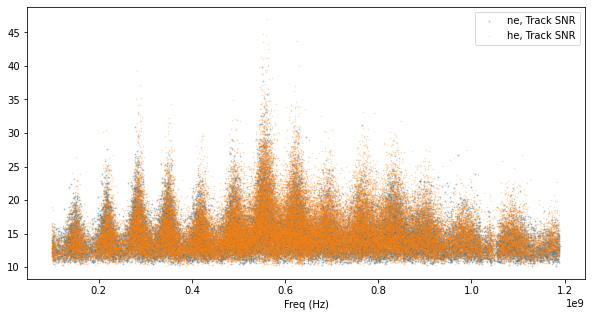

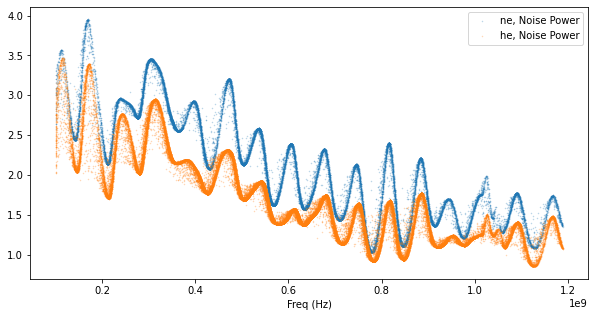

In [15]:
cut = 10
fig0, ax0 = plt.subplots(figsize=(10,5))
fig1, ax1 = plt.subplots(figsize=(10,5))
# fig2, ax2 = plt.subplots(figsize=(10,5))
for i,isotope in enumerate(snr_study.keys()):
    
    df = snr_study[isotope][cut].tracks
    MeanTrackSNR_normed = df.MeanTrackSNR 
    MeanNoise = df.TotalPower / df.TotalTrackSNR
    MeanNoise_normed = MeanNoise 
    # Scatter Plots
    ax0.plot(
        df.StartFrequency,
         MeanTrackSNR_normed,
        "o",
        markersize=1.0-i/2,
        alpha=.3,
        label = f"{isotope}, Track SNR"
    )
    ax1.plot(
        df.StartFrequency,
        MeanNoise_normed,
        "o",
        markersize=.5,
        alpha=.3,

        label = f"{isotope}, Noise Power"
    )
ax0.legend()
ax1.legend()
ax0.set_xlabel("Freq (Hz)")
ax1.set_xlabel("Freq (Hz)")
plt.show()

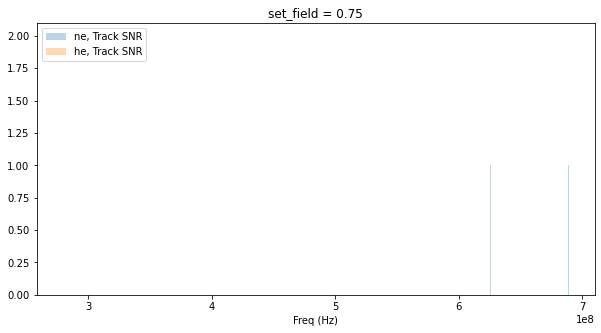

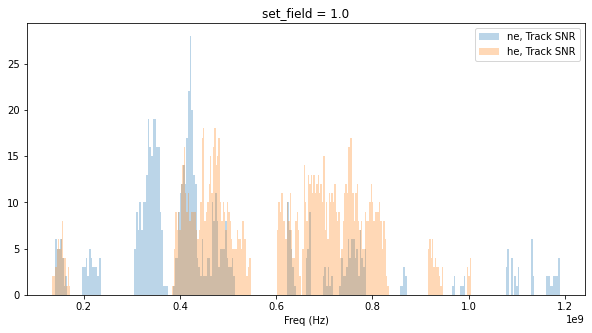

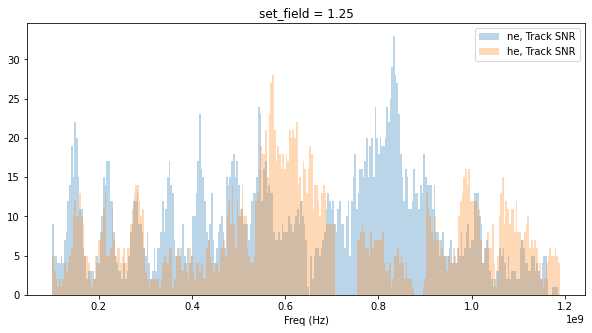

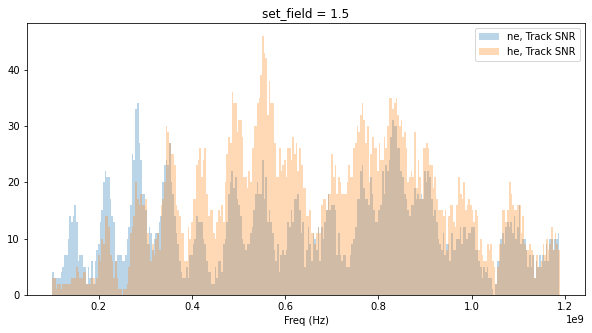

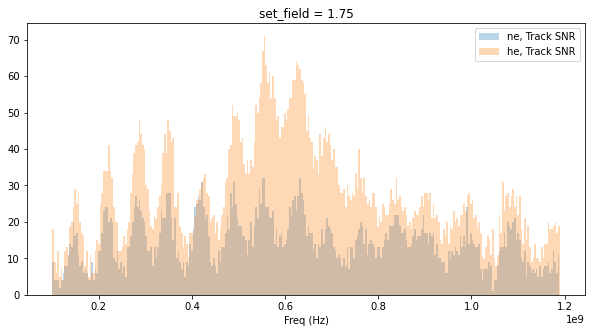

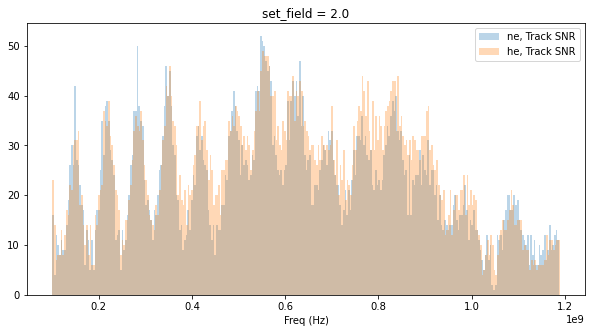

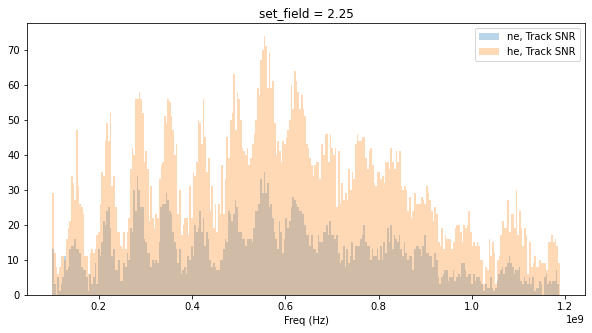

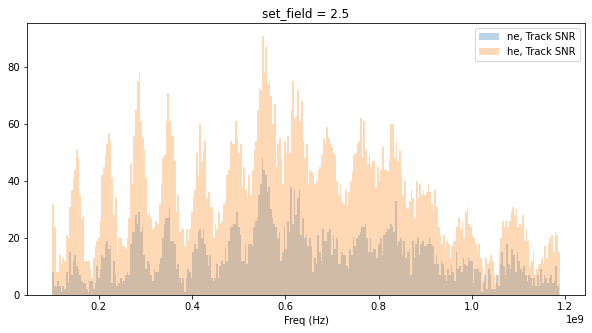

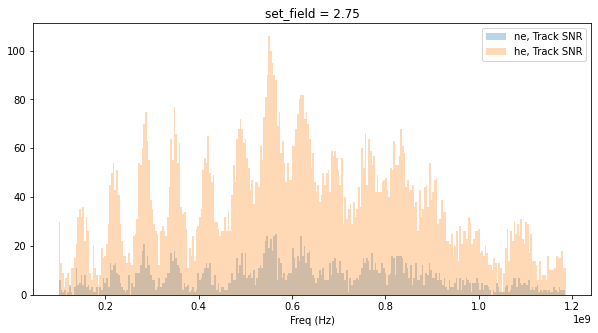

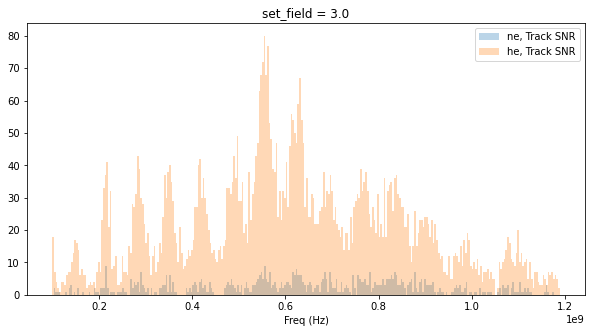

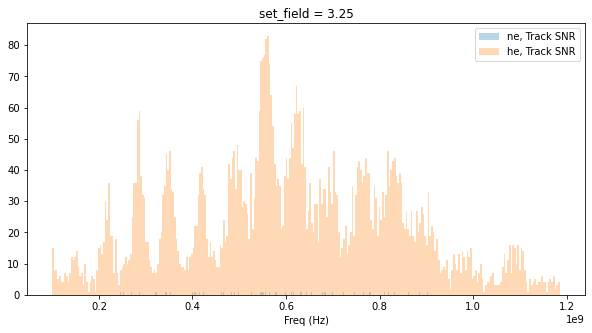

In [17]:
cut = 10
set_fields = np.arange(.75,3.5,.25)
# fig1, ax1 = plt.subplots(figsize=(10,5))
# fig2, ax2 = plt.subplots(figsize=(10,5))
for set_field in set_fields:
    fig0, ax0 = plt.subplots(figsize=(10,5))
    for i,isotope in enumerate(snr_study.keys()):
        
            df = snr_study[isotope][cut].tracks
            df = df[df.set_field == set_field]
            MeanTrackSNR_normed = df.MeanTrackSNR 
            MeanNoise = df.TotalPower / df.TotalTrackSNR
            MeanNoise_normed = MeanNoise 
            # Scatter Plots
            ax0.hist(
                df.StartFrequency,
                label = f"{isotope}, Track SNR",
                bins = 300,
                alpha = .3
            )

    ax0.legend()
    plt.title(f"set_field = {set_field}")
    ax0.set_xlabel("Freq (Hz)")
    # ax1.set_xlabel("Freq (Hz)")
    plt.show()

## OLD (DELETE LATER) NOW = 2/6/23

## MC function for comparison

In [12]:
def AUC_expectation(set_fields, freq_BWs, b = 0, plot = False): 
    
    integrate_vect = np.vectorize(integrate.quad)
    
    energy_acceptances_high = sc.freq_to_energy(
        freq_BWs[:,0], set_fields
    )
    energy_acceptances_low = sc.freq_to_energy(
        freq_BWs[:,1], set_fields
    )
    energy_acceptances = np.stack((energy_acceptances_low, energy_acceptances_high), axis=-1)
    
    # Empty dict to house relative rates. 
    rates = {}

    isotopes = {"Ne19": {"Wmax": 5.337377690802349, "Z": 9, "A": 19, "b": -b},
                "He6": {"Wmax": 7.864593361688904, "Z": 2, "A": 6, "b": b}}

    # This delta_W prevents a zero argument in a log. Doesn't effect pdfs
    delta_W = 10**-10
    
    if plot: 
        pdf_plot_pts = 10**2
        f, ax = plt.subplots(1, figsize=(10,5))

    for isotope_name, isotope_info in isotopes.items(): 

        W_low = sc.gamma(energy_acceptances[:, 0]) + delta_W
        W_high = sc.gamma(energy_acceptances[:, 1])-delta_W

        # Feed the info dict to the BetaSpectrum class. 
        bspec = bs.BetaSpectrum(isotope_info)
        
        fraction_of_spectrum, err = integrate_vect(
                bspec.dNdE,
                W_low,
                W_high,
            )
        rates[isotope_name] = fraction_of_spectrum
        
        if plot:
            Ws = np.linspace(W_low, W_high, pdf_plot_pts)
            pdf = bspec.dNdE(Ws)
            ax.plot(Ws, pdf)

    if plot: 
        ax.set_xlabel(r"$\gamma$")
        plt.title("He6 and Ne19 Spectra (pdf)")
        plt.show()


    for isotope in rates: 
        rates[isotope] = np.array(rates[isotope]) / np.array(rates[isotope]).sum()

    rates["set_fields"] = set_fields
    rates = pd.DataFrame(rates)
    
    # Make the ratio a column of the df
    rates["ratio"] = rates["Ne19"] / rates["He6"]
    
    rates.set_index("set_fields", inplace = True)
    return rates
